# Building the pipeline for working with EEG data

In this notebook
- we build the codes to extract initial raw data;
- we calculate different metrics as measures of functional connectivity;
- based on calculated measures like Mutual Information and Coherence we create Adjacency Matrices; 
- we create graphs based on the previously calculated metrics;
- make some plots to visualize the obtained graphs.

MAYBE based on graphs we will train some graph convolutional neural networks...

# 0 - Required packages



In [8]:
import sys
from glob2 import glob

import numpy as np
import pandas as pd # dataframes, tables 
import seaborn as sns # plotting
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

import mne
from mne.io import read_raw_edf
import networkx as nx

# 1 - Datasets Links

 Links for downloading the datasets: https://isip.piconepress.com/projects/tuh_eeg/html/downloads.shtml
 
 Command for getting the data from the server: 
- rsync -auxvL nedc@www.isip.piconepress.com:data/eeg/tuh_eeg_abnormal/v2.0.0/ . 
- rsync -auxvL nedc@www.isip.piconepress.com:data/eeg/tuh_eeg_epilepsy/v1.0.0/ .

TUH EEG Epilepsy Corpus. It was created to provide data for the purposes of automatic analysis of EEG. The patients were sorted by using a filter that categorized patients into two classes: epilepsy and not epilepsy. This was based on information in the session reports relating to their clinical history, medications at the time of recording, and EEG features associated with epilepsy. 
This subset contains European data format (EDF) files and corresponding neurologist reports for 1,648 files in  561 sessions from 200 patients. From these, 1473 files in 436 sessions from 100 patients have epilepsy, whereas 326 files in 134 sessions from 100 patients do not have epilepsy.
link: https://isip.piconepress.com/conferences/ieee_spmb/2017/papers/p01_13.pdf

FILENAME STRUCTURE "TUH EEG Epilepsy Corpus.":

 A typical filename in this corpus is: edf/epilepsy/01_tcp_ar/003/00000355/s003_2013_01_04/00000355_s003_t000.edf

 The first segment, "edf/", is a directory name for the directory containing the data, which consists of edf files (*.edf) and EEG reports (*.txt).

 The second segment denotes either patients with epilepsy ("/epilepsy") or patients with without epilepsy ("/no_epilepsy").

 The third segment ("/01_tcp_ar") denotes the type of channel configuration for the EEG. "/01_tcp_ar" refers to an AR reference configuration.

 The fourth segment ("003") is a three-digit identifier meant to keep the number of subdirectories in a directory manageable. This follows the TUH EEG v1.1.0 convention.

 The fifth segment ("/00000355") denotes an anonymized patient ID. The IDs are consistent across all of our databases involving Temple
 Hospital EEG data.

 The sixth segment ("/s003_2013_01_04") denotes the session number("s003"), and the date the EEG was archived at the hospital("01/04/2013").

 The seventh, or last, segment is the filename ("00000355_s003_t000.edf"). This includes the patient number, the session number and a token number ("t000").

 Sessions were sorted into epilepsy and no epilepsy categories by searching the associated EEG reports for indications as to a epilepsy/no epilepsy 
 diagnosis based on clinical history, medications at the time of recording, and EEG features associated with epilepsy such as spike and sharp waves. 


## 1.1 - Loading data from .edf files

In [9]:
# reading the list of file names in the EEG Epilepsy Corpus
edf_file_list = glob("../tuh_eeg_epilepsy/edf/*/*/*/*/*/*.edf")


#edf_file_list = glob("../tuh_eeg_abnormal/edf/*/*/*/*/*/*/*.edf")
len(edf_file_list)

1648

There are 1648 with data files in the TUH Epilepsy database.

In [3]:
# print out several filenames
edf_file_list[:4]

['../tuh_eeg_epilepsy/edf/epilepsy/03_tcp_ar_a/076/00007656/s010_2011_03_13/00007656_s010_t000.edf',
 '../tuh_eeg_epilepsy/edf/epilepsy/03_tcp_ar_a/076/00007656/s010_2011_03_13/00007656_s010_t001.edf',
 '../tuh_eeg_epilepsy/edf/epilepsy/03_tcp_ar_a/076/00007656/s010_2011_03_13/00007656_s010_t003.edf',
 '../tuh_eeg_epilepsy/edf/epilepsy/03_tcp_ar_a/076/00007656/s010_2011_03_13/00007656_s010_t002.edf']

In [10]:
# extract subject IDs from the file path, create python set to extract unique elements from list, convert to list again 
unique_epilepsy_patient_ids = list(set([x.split("/")[-1].split("_")[0] for x in edf_file_list]))
len(unique_epilepsy_patient_ids)

200

There are 200 unique patients in the database.

In [5]:
# write down the list all the patient IDs into one file for later use
# with open('./epilepsy_corpus_subjects.txt', 'w') as file_handler:
    # for item in unique_epilepsy_patient_ids:
    #     file_handler.write("{}\n".format(item))

In [5]:
edf_file_list[0].split("/")

['..',
 'tuh_eeg_epilepsy',
 'edf',
 'epilepsy',
 '03_tcp_ar_a',
 '076',
 '00007656',
 's010_2011_03_13',
 '00007656_s010_t000.edf']

In [11]:
def read_edf_to_pandas(edf_filename, select_channels = True):
    """ Reads data from an edf file to a Pandas dataframe.
        Column names are 'channel_labels'.
        
        If 'select_channels=True', then only 19 common channels are selected to 
        create the resulting dataframe. The channel names will be updated (standardized).
        
        Returns: dataframe, channel labels
    """
    # read edf file
    raw_data = read_raw_edf(edf_filename, verbose=False, preload=False)
    
    if select_channels:
        # the TUEP database has 3 EEG channel configurations: '02_tcp_le', '03_tcp_ar_a', '01_tcp_ar'
        # number of channels and channel names differ within these configurations
        # to be able to compare the different EEG readings we need to select channels
        # that are common for all configurations

        # the list of 19 channels (their short labels) that we will use for analysing EEG data
        channels_to_use = ['FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8',
                           'T3', 'C3', 'CZ', 'C4', 'T4', 'T5',
                           'P3', 'PZ', 'P4', 'T6', 'O1', 'O2']
        
        # the function to update channel names from original to new format:
        ch_name_update_func = lambda ch: ch.split(' ')[-1].split('-')[0]

        # renaming the original channel names in one .edf file;
        # the update will be written into the in-memory edf object
        raw_data.rename_channels(mapping=ch_name_update_func)
        
        # check if all required channels are in the edf file
        try:
            assert all([ch in raw_data.info["ch_names"] for ch in channels_to_use])
        except:
            print('Not all required channels are in the edf file.')
        
        # dataframe with EEG readings from selected channels and with 
        # updated channel names
        df = pd.DataFrame(raw_data.pick_channels(channels_to_use).get_data().T,
            columns=raw_data.pick_channels(channels_to_use).info['ch_names'])
        
        # we need to return correct channel/column names
        channel_labels = channels_to_use # as specified by us: left-to-right and top-down
        # channel_labels = df.columns.tolist() # as given in the edf file
        
    else:
        # get channel names from edf file
        channel_labels = raw_data.info["ch_names"]

        # create a dataframe from
        df = pd.DataFrame(raw_data.get_data().T, columns=channel_labels)

    return df[channel_labels], channel_labels # as specified by us: left-to-right and top-down
    # return df, channel_labels # as given in the edf file


In [12]:
edf_file_epilepsy = '../tuh_eeg_epilepsy/edf/epilepsy/03_tcp_ar_a/076/00007656/s010_2011_03_13/00007656_s010_t000.edf'
edf_file_no_epilepsy = '../tuh_eeg_epilepsy/edf/no_epilepsy/03_tcp_ar_a/076/00007671/s002_2011_02_03/00007671_s002_t002.edf'
signle_edf_name = (edf_file_no_epilepsy, edf_file_epilepsy)

In [13]:
raw_data_epilepsy = read_raw_edf(edf_file_epilepsy,
                       verbose=0, preload=False)

raw_data_no_epilepsy = read_raw_edf(edf_file_no_epilepsy,
                       verbose=0, preload=False)

single_edf_file = (raw_data_no_epilepsy, raw_data_epilepsy)

In [14]:
df_, ch_ = read_edf_to_pandas(edf_file_epilepsy)

In [15]:
df_.head()

FP1       FP2        F7        F3        FZ        F4        F8  \
0 -0.000055 -0.000034 -0.000066 -0.000044 -0.000035 -0.000037 -0.000025   
1 -0.000053 -0.000024 -0.000067 -0.000055 -0.000026 -0.000031 -0.000014   
2 -0.000057 -0.000037 -0.000072 -0.000054 -0.000037 -0.000039 -0.000029   
3 -0.000062 -0.000049 -0.000074 -0.000044 -0.000048 -0.000045 -0.000041   
4 -0.000060 -0.000037 -0.000070 -0.000045 -0.000038 -0.000037 -0.000028   

         T3        C3        CZ        C4        T4        T5        P3  \
0 -0.000061 -0.000019 -0.000011 -0.000018 -0.000022 -0.000046 -0.000023   
1 -0.000055 -0.000013 -0.000005 -0.000012 -0.000012 -0.000046 -0.000016   
2 -0.000068 -0.000025 -0.000013 -0.000020 -0.000027 -0.000051 -0.000028   
3 -0.000078 -0.000035 -0.000021 -0.000026 -0.000038 -0.000054 -0.000038   
4 -0.000068 -0.000025 -0.000013 -0.000018 -0.000026 -0.000050 -0.000028   

         PZ        P4        T6        O1            O2  
0 -0.000015 -0.000013 -0.000017 -0.000019 -3.306223e-07  
1 -0.000011 -0.000011 -0.000009 -0.000035  7.365690e-06  
2 -0.000019 -0.000019 -0.000021 -0.000030 -6.521134e-06  
3 -0.000026 -0.000022 -0.000031 -0.000016 -1.789829e-05  
4 -0.000020 -0.000015 -0.000021 -0.000019 -7.023068e-06

## 1.3 - Function for computing and plotting the Correlation Matrix

In [16]:
def compute_corr_matrix(edf_filename):
    
    # read edf file from filename
    # by default, common channels will be selected and renamed
    df, channel_labels = read_edf_to_pandas(edf_filename)
    
    # calculate the correlation matrix
    corr_matrix = df.corr()
    
    return corr_matrix

def proportional_thresholding(matrix_a, percentile=0):

    threshold = np.percentile(matrix_a, q=percentile)
    matrix_b = copy(matrix_a)
    matrix_b[matrix_a<threshold] = 0

    return matrix_b

def plot_correlation_matrix(edf_filename, prop_thresholding=False):
    """ Reads edf file from relative path (ex. ../tuh_eeg_epilepsy/edf/*/*/*/*/*/*.edf). 
        Creates a dataframe with all EEG readings from all channels.
        Computes a correlation matrix.
    """
    # read edf file from filename
    # by default, common channels will be selected and renamed
    df, channel_labels = read_edf_to_pandas(edf_filename)
    
    # calculate the correlation matrix
    corr_matrix = df.corr()
    
    if prop_thresholding:
        corr_matrix = proportional_thresholding(corr_matrix, percentile=50)

    # plot the heatmap for correlation matrix
    fig, ax = plt.subplots(1,1, figsize=(8,6))
    sns.heatmap(corr_matrix,
                xticklabels=channel_labels, 
                yticklabels=channel_labels,
                cmap= plt.cm.jet,
                ax = ax)
    
    plt.title('Correlation Matrix')
    plt.xlabel('EEG channels')
    plt.ylabel('EEG channels')
     
    # return fig
    

### 1.3.1 - Plots (heatmaps) of correlation matrices

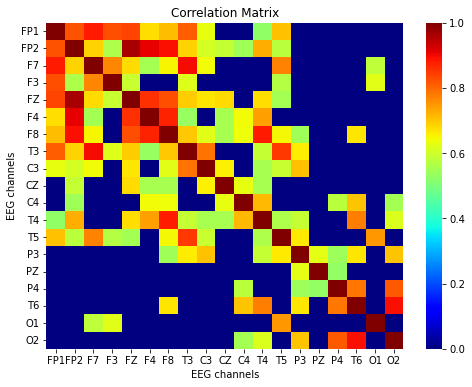

In [528]:
df, channel_labels = read_edf_to_pandas(edf_file_epilepsy)
# calculate the correlation matrix
corr_matrix = df.corr()


# plot the heatmap for correlation matrix
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.heatmap(proportional_thresholding(corr_matrix, percentile=50),
            xticklabels=channel_labels, 
            yticklabels=channel_labels,
            cmap= plt.cm.jet,
            ax = ax)

plt.title('Correlation Matrix')
plt.xlabel('EEG channels')
plt.ylabel('EEG channels')
# plt.savefig('corr_mat_epilepsy_prop_thresh_50pct.pdf', dpi=150, bbox_inches='tight')

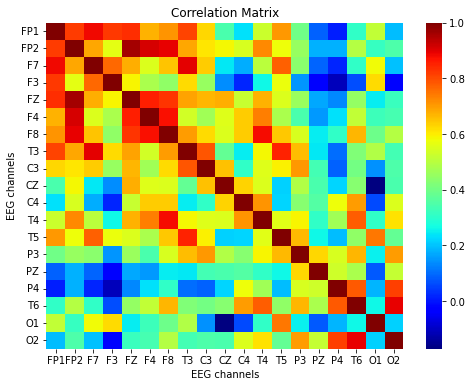

In [530]:
plot_correlation_matrix(edf_filename=edf_file_epilepsy, prop_thresholding=False)
# plt.savefig('corr_mat_epilepsy.pdf', dpi=150, bbox_inches='tight')

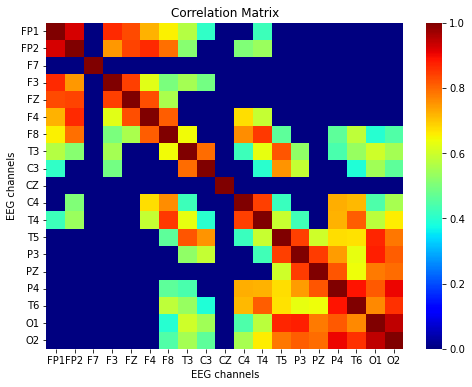

In [531]:
df, channel_labels = read_edf_to_pandas(edf_file_no_epilepsy)
# calculate the correlation matrix
corr_matrix = df.corr()

# plot the heatmap for correlation matrix
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.heatmap(proportional_thresholding(corr_matrix, percentile=50),
            xticklabels=channel_labels, 
            yticklabels=channel_labels,
            cmap= plt.cm.jet,
            ax = ax)

plt.title('Correlation Matrix')
plt.xlabel('EEG channels')
plt.ylabel('EEG channels')
# plt.savefig('corr_mat_no_epilepsy_prop_thresh_50pct.pdf', dpi=150, bbox_inches='tight')

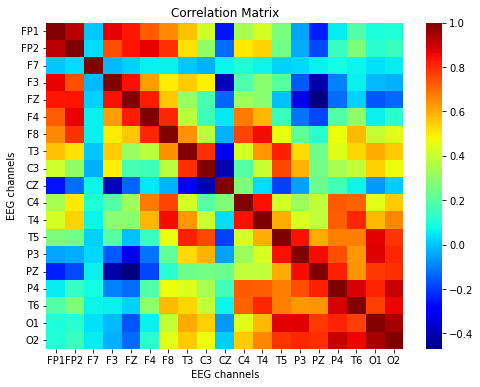

In [532]:
plot_correlation_matrix(edf_filename=edf_file_no_epilepsy)
# plt.savefig('corr_mat_no_epilepsy.pdf', dpi=150, bbox_inches='tight')

In [17]:
raw_data_no_epilepsy.info.keys()

dict_keys(['acq_pars', 'acq_stim', 'ctf_head_t', 'description', 'dev_ctf_t', 'dig', 'experimenter', 'utc_offset', 'device_info', 'file_id', 'highpass', 'hpi_subsystem', 'kit_system_id', 'helium_info', 'line_freq', 'lowpass', 'meas_date', 'meas_id', 'proj_id', 'proj_name', 'subject_info', 'xplotter_layout', 'gantry_angle', 'bads', 'chs', 'comps', 'events', 'hpi_meas', 'hpi_results', 'projs', 'proc_history', 'custom_ref_applied', 'sfreq', 'dev_head_t', 'ch_names', 'nchan'])

In [18]:
def rename_channels(raw_data):
    # the list of 19 channels (their short labels) that we will use for analysing EEG data
    channels_to_use = ['FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8',
                        'T3', 'C3', 'CZ', 'C4', 'T4', 'T5',
                        'P3', 'PZ', 'P4', 'T6', 'O1', 'O2']

    # the function to update channel names from original to new format:
    ch_name_update_func = lambda ch: ch.split(' ')[-1].split('-')[0]

    # renaming the original channel names in one .edf file;
    # the update will be written into the in-memory edf object
    raw_data.rename_channels(mapping=ch_name_update_func)

    return raw_data

In [ ]:
channels_to_use = ['FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8',
                        'T3', 'C3', 'CZ', 'C4', 'T4', 'T5',
                        'P3', 'PZ', 'P4', 'T6', 'O1', 'O2']
# raw_data_no_epilepsy = rename_channels(raw_data_no_epilepsy)
raw_data_no_epilepsy.pick_channels(channels_to_use)

In [123]:
delta_freq_band = (1,4)
theta_freq_band = (4,8)
alpha_freq_band = (8,12)
beta_freq_band = (12,30)
gamma_freq_band = (30,100)
all_bands = (1,40)

freq_bands = [(1,40), (1,4), (4,8), (8,12), (12,30)]

In [25]:
def filter_data(filename, l_freq, h_freq):

    raw = read_raw_edf(filename, verbose=0, preload=False)
    sfreq = raw.info['sfreq']
    
    df, ch = read_edf_to_pandas(filename)
    df_filt = mne.filter.filter_data(data=df.T.values, sfreq=sfreq,
                                    l_freq=l_freq, h_freq=h_freq,
                                    n_jobs=-2,  verbose=False)
    
    return pd.DataFrame(df_filt.T, columns=ch)


Text(51.0, 0.5, 'channel_names')

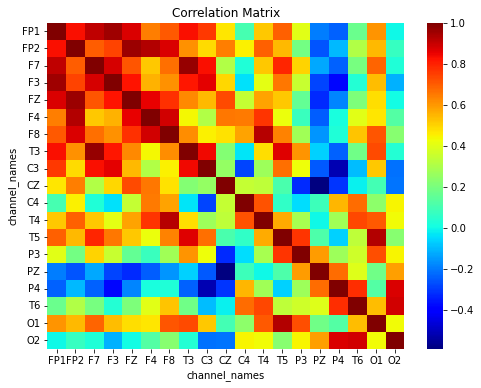

In [30]:
df_filt = filter_data(edf_file_epilepsy, l_freq=1, h_freq=4)

# calculate the correlation matrix
corr_matrix = df_filt.corr()
        
# plot the heatmap for correlation matrix
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.heatmap(corr_matrix,
            xticklabels=df_filt.columns.tolist(), 
            yticklabels=df_filt.columns.tolist(),
            cmap= plt.cm.jet,
            ax = ax)

plt.title('Correlation Matrix')
plt.xlabel('channel_names')
plt.ylabel('channel_names')

Text(51.0, 0.5, 'channel_names')

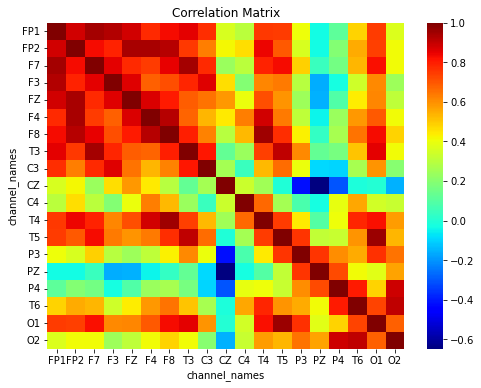

In [131]:
df_filt = filter_data(edf_file_epilepsy, l_freq=4, h_freq=8)

# calculate the correlation matrix
corr_matrix = df_filt.corr()
        
# plot the heatmap for correlation matrix
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.heatmap(corr_matrix,
            xticklabels=df_filt.columns.tolist(), 
            yticklabels=df_filt.columns.tolist(),
            cmap= plt.cm.jet,
            ax = ax)

plt.title('Correlation Matrix')
plt.xlabel('channel_names')
plt.ylabel('channel_names')

Text(51.0, 0.5, 'channel_names')

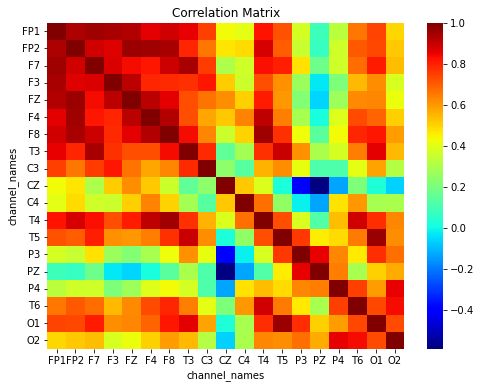

In [132]:
df_filt = filter_data(edf_file_epilepsy, l_freq=8, h_freq=12)

# calculate the correlation matrix
corr_matrix = df_filt.corr()
        
# plot the heatmap for correlation matrix
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.heatmap(corr_matrix,
            xticklabels=df_filt.columns.tolist(), 
            yticklabels=df_filt.columns.tolist(),
            cmap= plt.cm.jet,
            ax = ax)

plt.title('Correlation Matrix')
plt.xlabel('channel_names')
plt.ylabel('channel_names')

Text(51.0, 0.5, 'channel_names')

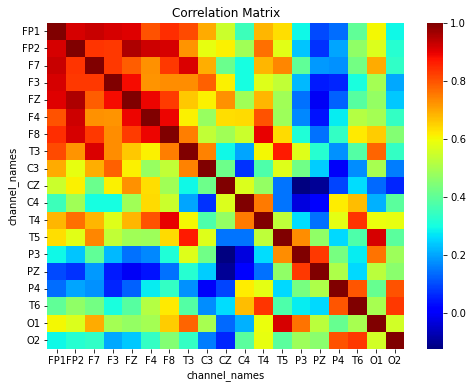

In [133]:
df_filt = filter_data(edf_file_epilepsy, l_freq=12, h_freq=30)

# calculate the correlation matrix
corr_matrix = df_filt.corr()
        
# plot the heatmap for correlation matrix
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.heatmap(corr_matrix,
            xticklabels=df_filt.columns.tolist(), 
            yticklabels=df_filt.columns.tolist(),
            cmap= plt.cm.jet,
            ax = ax)

plt.title('Correlation Matrix')
plt.xlabel('channel_names')
plt.ylabel('channel_names')

Text(51.0, 0.5, 'channel_names')

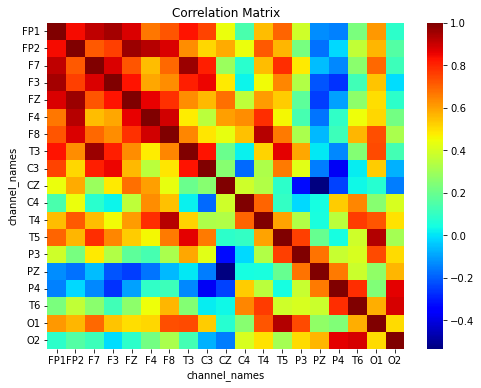

In [134]:
df_filt = filter_data(edf_file_epilepsy, l_freq=1, h_freq=40)

# calculate the correlation matrix
corr_matrix = df_filt.corr()
        
# plot the heatmap for correlation matrix
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.heatmap(corr_matrix,
            xticklabels=df_filt.columns.tolist(), 
            yticklabels=df_filt.columns.tolist(),
            cmap= plt.cm.jet,
            ax = ax)

plt.title('Correlation Matrix')
plt.xlabel('channel_names')
plt.ylabel('channel_names')

Text(51.0, 0.5, 'channel_names')

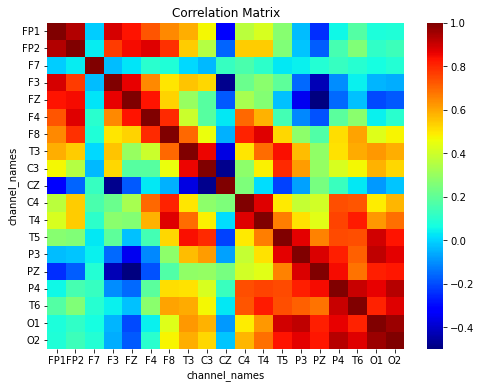

In [135]:
df_filt = filter_data(edf_file_no_epilepsy, l_freq=1, h_freq=4)

# calculate the correlation matrix
corr_matrix = df_filt.corr()
        
# plot the heatmap for correlation matrix
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.heatmap(corr_matrix,
            xticklabels=df_filt.columns.tolist(), 
            yticklabels=df_filt.columns.tolist(),
            cmap= plt.cm.jet,
            ax = ax)

plt.title('Correlation Matrix')
plt.xlabel('channel_names')
plt.ylabel('channel_names')

Text(51.0, 0.5, 'channel_names')

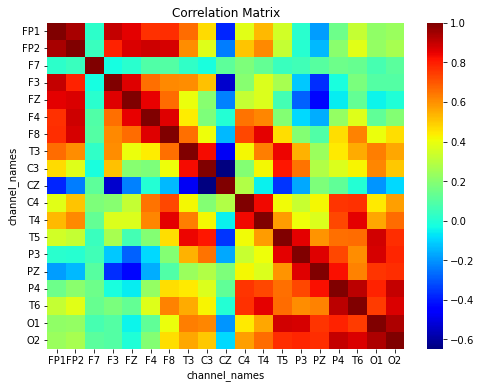

In [136]:
df_filt = filter_data(edf_file_no_epilepsy, l_freq=4, h_freq=8)

# calculate the correlation matrix
corr_matrix = df_filt.corr()
        
# plot the heatmap for correlation matrix
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.heatmap(corr_matrix,
            xticklabels=df_filt.columns.tolist(), 
            yticklabels=df_filt.columns.tolist(),
            cmap= plt.cm.jet,
            ax = ax)

plt.title('Correlation Matrix')
plt.xlabel('channel_names')
plt.ylabel('channel_names')

Text(51.0, 0.5, 'channel_names')

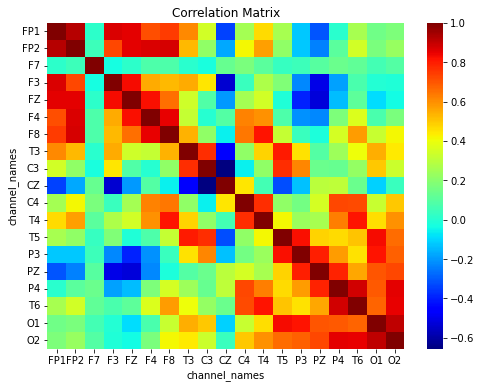

In [137]:
df_filt = filter_data(edf_file_no_epilepsy, l_freq=8, h_freq=12)

# calculate the correlation matrix
corr_matrix = df_filt.corr()
        
# plot the heatmap for correlation matrix
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.heatmap(corr_matrix,
            xticklabels=df_filt.columns.tolist(), 
            yticklabels=df_filt.columns.tolist(),
            cmap= plt.cm.jet,
            ax = ax)

plt.title('Correlation Matrix')
plt.xlabel('channel_names')
plt.ylabel('channel_names')

Text(51.0, 0.5, 'channel_names')

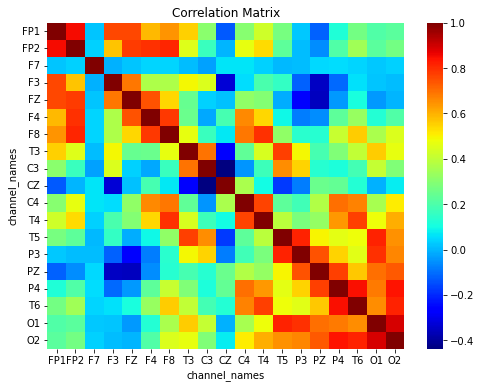

In [138]:
df_filt = filter_data(edf_file_no_epilepsy, l_freq=12, h_freq=30)
# calculate the correlation matrix
corr_matrix = df_filt.corr()
        
# plot the heatmap for correlation matrix
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.heatmap(corr_matrix,
            xticklabels=df_filt.columns.tolist(), 
            yticklabels=df_filt.columns.tolist(),
            cmap= plt.cm.jet,
            ax = ax)

plt.title('Correlation Matrix')
plt.xlabel('channel_names')
plt.ylabel('channel_names')

Text(51.0, 0.5, 'channel_names')

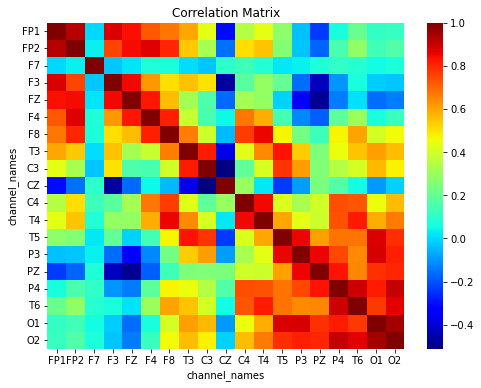

In [139]:
df_filt = filter_data(edf_file_no_epilepsy, l_freq=1, h_freq=40)

# calculate the correlation matrix
corr_matrix = df_filt.corr()
        
# plot the heatmap for correlation matrix
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.heatmap(corr_matrix,
            xticklabels=df_filt.columns.tolist(), 
            yticklabels=df_filt.columns.tolist(),
            cmap= plt.cm.jet,
            ax = ax)

plt.title('Correlation Matrix')
plt.xlabel('channel_names')
plt.ylabel('channel_names')

## 1.4 - Function for computing and plotting the Mutual Information Matrix

In [26]:
def entropy(bins, *X):
    
    # binning of the data
    data, *edges = np.histogramdd(X, bins=bins)
    
    # calculate probabilities
    data = data.astype(float)/data.sum()
    
    # compute H(X,Y,...,Z) = sum(-P(x,y,...,z) ∗ log2(P(x,y,...,z)))
    return np.sum(-data * np.log2(data+sys.float_info.epsilon))


def mutual_information(bins, X, Y):
    
    # compute I(X,Y) = H(X) + H(Y) − H(X,Y)
    
    H_X = entropy(bins, X)
    H_Y = entropy(bins, Y)
    H_XY = entropy(bins, X, Y)
    
    return H_X + H_Y - H_XY

# Compute number of bins using Sturge's rule
def compute_mi_matrix(df):
    """ Compute Mutual Information matrix.
    
        Return: mi_matrix
    """
    n_cols = df.shape[1]
    mi_matrix = np.zeros([n_cols, n_cols])
    
    # Sturge's rule for number of bins
    n_bins = int(1 + 3.322*np.log10(df.shape[0]))
    
    for i in range(n_cols):
        for j in range(n_cols):
            mi = mutual_information(n_bins, df.iloc[:,i],df.iloc[:,j])
            mi_matrix[i,j] = mi
    
    return mi_matrix
    

def compute_normed_mi_matrix(mi_matrix):
    """ Compute normalized version of the given Mutual Information matrix.
    
        Return: normed_mi_matrix
    """
    
    # normalize mi matrix by dividing matrix elements with
    # sqrt of product of respective diagonal elements
    divisor_matrix = np.sqrt(np.diag(mi_matrix)*np.diag(mi_matrix).reshape(-1,1))
    normed_mi_matrix = mi_matrix/divisor_matrix

    return normed_mi_matrix

In [27]:
def plot_mutual_information_matrix(edf_filename, prop_thresholding=False):
    """ Reads edf file from relative path (ex. ../tuh_eeg_epilepsy/edf/*/*/*/*/*/*.edf). 
        Creates a dataframe with all EEG readings from all channels.
        Computes a mutual information matrix.
    """
    # read edf file from filename
    # by default, common channels will be selected and renamed
    df, channel_labels = read_edf_to_pandas(edf_filename)

    # calculate the normalized mutual information matrix
    mi_matrix = compute_mi_matrix(df)
    
    if prop_thresholding:
        mi_matrix = proportional_thresholding(mi_matrix, percentile=50)

    # plot the heatmap for mutual information matrix
    fig, ax = plt.subplots(1,1, figsize=(8,6))
    sns.heatmap(mi_matrix,
                xticklabels=channel_labels, 
                yticklabels=channel_labels,
                cmap= plt.cm.jet,
                ax = ax)
    
    plt.title('Mutual Information Matrix')
    plt.xlabel('channel_names')
    plt.ylabel('channel_names')


def plot_normed_mutual_information_matrix(edf_filename, prop_thresholding=False):
    """ Reads edf file from relative path (ex. ../tuh_eeg_epilepsy/edf/*/*/*/*/*/*.edf). 
        Creates a dataframe with all EEG readings from all channels.
        Computes a normalized mutual information matrix.
    """
    # read edf file from filename
    # by default, common channels will be selected and renamed
    df, channel_labels = read_edf_to_pandas(edf_filename)

    # calculate the normalized mutual information matrix
    mi_matrix = compute_mi_matrix(df)
    normed_mi_matrix = compute_normed_mi_matrix(mi_matrix)

    if prop_thresholding:
        normed_mi_matrix = proportional_thresholding(normed_mi_matrix, percentile=50)

    # plot the heatmap for mutual information matrix
    fig, ax = plt.subplots(1,1, figsize=(8,6))
    sns.heatmap(normed_mi_matrix,
                xticklabels=channel_labels, 
                yticklabels=channel_labels,
                cmap= plt.cm.jet,
                ax = ax)
    
    plt.title('Mutual Information Matrix')
    plt.xlabel('EEG channels')
    plt.ylabel('EEG channels')

### 1.4.1 - Plots (heatmaps) of NOT normalized mutual information matrices

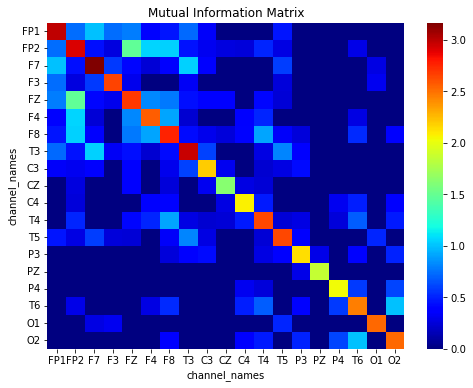

In [518]:
plot_mutual_information_matrix(edf_filename=edf_file_epilepsy, prop_thresholding=True)
# plot_mutual_information_matrix(edf_filename=edf_file_no_epilepsy, bins = 20)
# plt.savefig('mi_mat_epilepsy_prop_thresh_50pct.pdf', dpi=150, bbox_inches='tight')

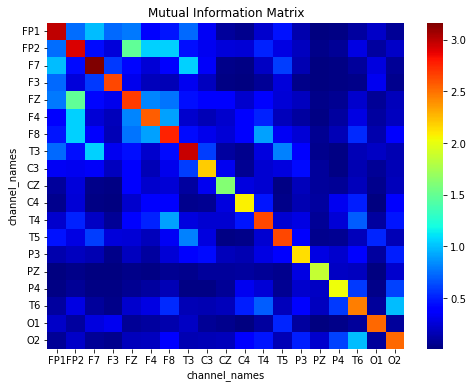

In [33]:
plot_mutual_information_matrix(edf_filename=edf_file_epilepsy)
# plot_mutual_information_matrix(edf_filename=edf_file_no_epilepsy, bins = 20)
# plt.savefig('mi_mat_epilepsy.pdf', dpi=150, bbox_inches='tight')

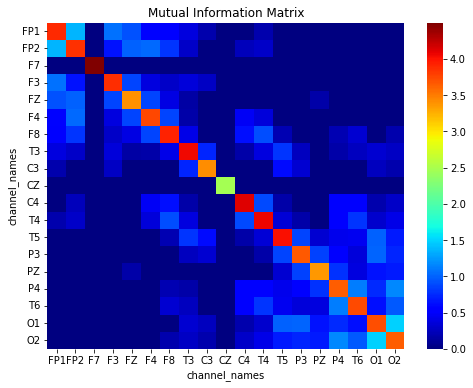

In [520]:
plot_mutual_information_matrix(edf_filename=edf_file_no_epilepsy, prop_thresholding=True)
# plot_mutual_information_matrix(edf_filename=edf_file_no_epilepsy, bins = 20)
# plt.savefig('mi_mat_no_epilepsy_prop_thresh_50pct.pdf', dpi=150, bbox_inches='tight')

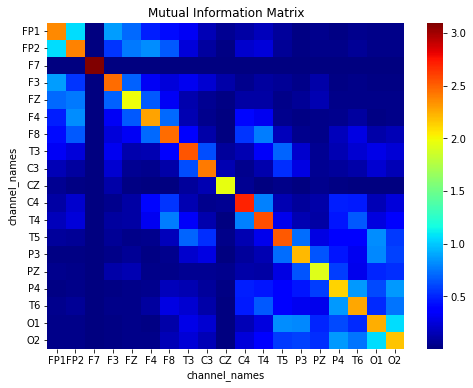

In [58]:
plot_mutual_information_matrix(edf_filename=edf_file_no_epilepsy)
# plot_mutual_information_matrix(edf_filename=edf_file_no_epilepsy, bins = 20)
# plt.savefig('mi_mat_no_epilepsy.pdf', dpi=150, bbox_inches='tight')

### 1.4.2 - Plots (heatmaps) of normalized mutual information matrices

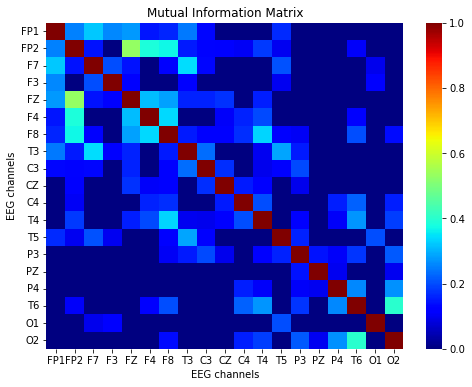

In [523]:
plot_normed_mutual_information_matrix(edf_filename=edf_file_epilepsy, prop_thresholding=True)
# plot_mutual_information_matrix(edf_filename=edf_file_no_epilepsy, bins = 20)
# plt.savefig('normed_mi_mat_epilepsy_prop_thresh_50pct.pdf', dpi=150, bbox_inches='tight')

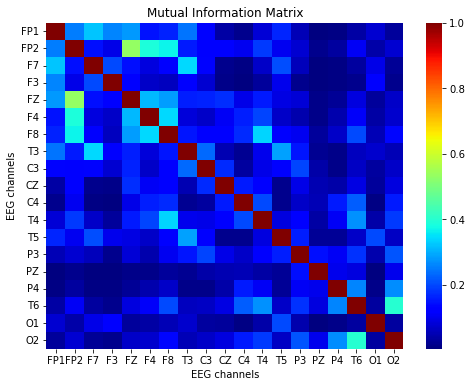

In [524]:
plot_normed_mutual_information_matrix(edf_filename=edf_file_epilepsy)
# plot_mutual_information_matrix(edf_filename=edf_file_no_epilepsy, bins = 20)
#plt.savefig('normed_mi_mat_epilepsy.pdf', dpi=150, bbox_inches='tight')

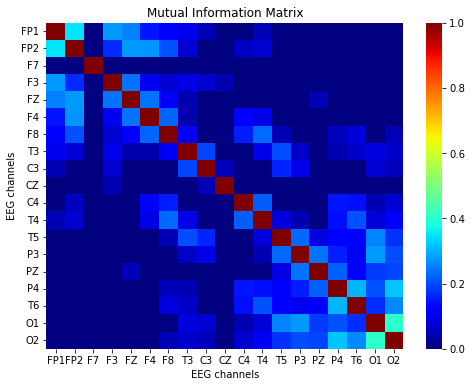

In [527]:
plot_normed_mutual_information_matrix(edf_filename=edf_file_no_epilepsy, prop_thresholding=True)
# plot_mutual_information_matrix(edf_filename=edf_file_no_epilepsy, bins = 20)
#plt.savefig('normed_mi_mat_no_epilepsy_prop_thresh_50pct.pdf', dpi=150, bbox_inches='tight')

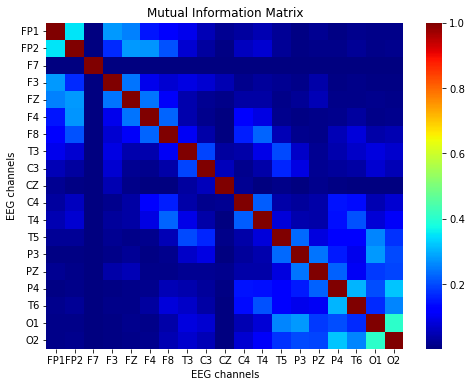

In [525]:
plot_normed_mutual_information_matrix(edf_filename=edf_file_no_epilepsy)
# plot_mutual_information_matrix(edf_filename=edf_file_no_epilepsy, bins = 20)
#plt.savefig('normed_mi_mat_no_epilepsy.pdf', dpi=150, bbox_inches='tight')

## 1.5 - Hierarchical clustering and Dendrogram

In [28]:
def plot_dendogram(matrix, channel_labels):

    fig, ax = plt.subplots(1,1, figsize=(10,7))
    
    linkage_data = linkage(matrix,
                           metric = "euclidean",
                           method = "ward")
    
    dendrogram_plt = dendrogram(linkage_data,
                                labels = channel_labels,
                                ax = ax
                               )
    
    plt.title('Dendrogram')
    plt.xlabel('EEG channels')
    plt.ylabel('Euclidean distances')
    
    return dendrogram_plt, linkage_data

### 1.5.1 - Dendrograms and clustermaps for NOT normalized mutual information matrices

In [29]:
# read edf file from filename
df, channel_labels = read_edf_to_pandas(edf_file_epilepsy)

# calculate the mutual information matrix
mi_matrix_epilepsy = compute_mi_matrix(df=df)


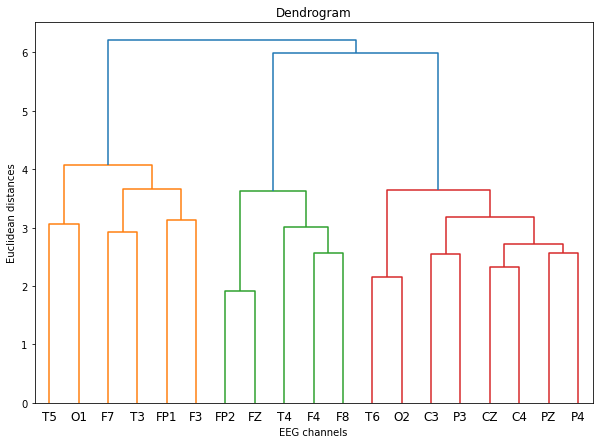

In [536]:
dendrogram_plt, linkage_data = plot_dendogram(mi_matrix_epilepsy, channel_labels)
# plt.savefig('dendr_mi_epilepsy.pdf', dpi=150, bbox_inches='tight')

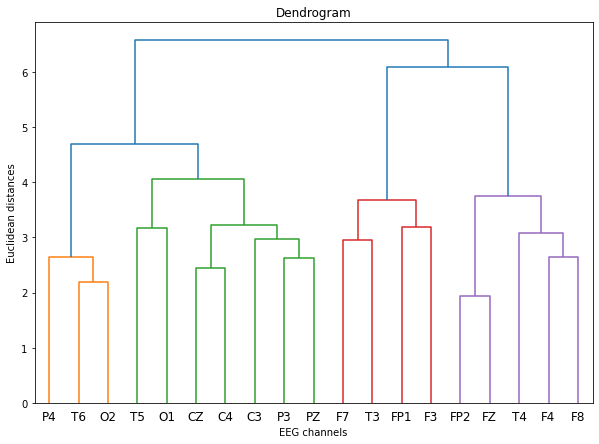

In [537]:
dendrogram_plt, linkage_data = plot_dendogram(proportional_thresholding(mi_matrix_epilepsy, percentile=50), channel_labels)

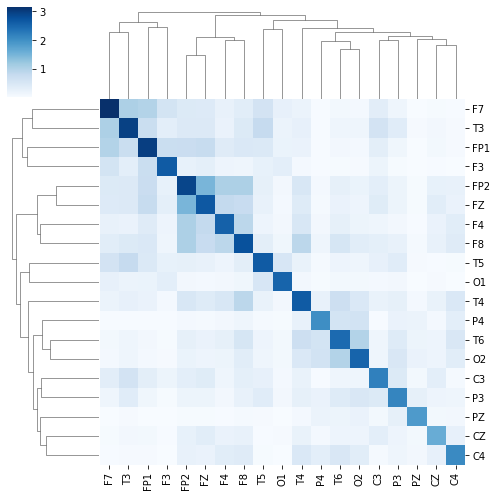

In [15]:
mi_df = pd.DataFrame(mi_matrix_epilepsy, columns=channel_labels, index=channel_labels)
sns.clustermap(mi_df,  cmap="Blues", figsize=(7,7))
# plt.savefig('clustermap_mi_epilepsy.pdf', dpi=150, bbox_inches='tight')

In [546]:
# read edf file from filename
df, channel_labels = read_edf_to_pandas(edf_file_no_epilepsy)

# calculate the mutual information matrix
mi_matrix_no_epilepsy = compute_mi_matrix(df=df)

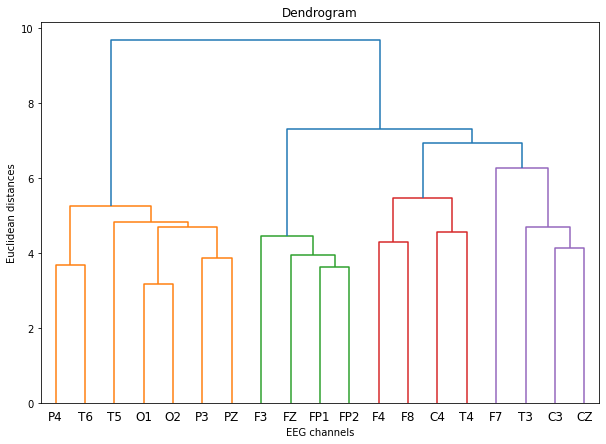

In [547]:
dendrogram_plt, linkage_data = plot_dendogram(mi_matrix_no_epilepsy, channel_labels)
# plt.savefig('dendr_mi_no_epilepsy.pdf', dpi=150, bbox_inches='tight')

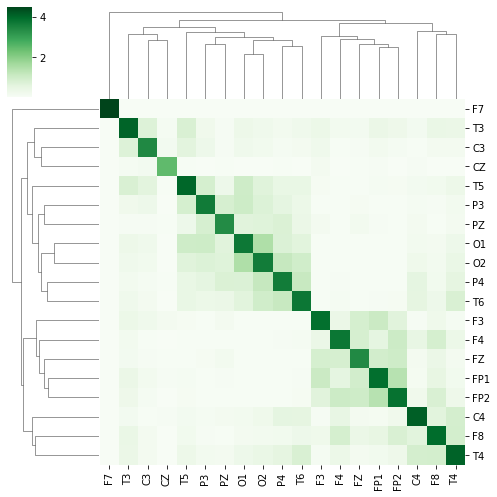

In [58]:
mi_df = pd.DataFrame(mi_matrix_no_epilepsy, columns=channel_labels, index=channel_labels)
fg = sns.clustermap(mi_df,  cmap="Greens", figsize=(7,7))
# plt.savefig('clustermap_mi_no_epilepsy.pdf', dpi=150, bbox_inches='tight')

### 1.5.2 - Dendrograms for normalized mutual information matrices

In [30]:
# read edf file from filename
df, channel_labels = read_edf_to_pandas(edf_file_epilepsy)

# calculate the mutual information matrix
normed_mi_matrix_epilepsy = compute_normed_mi_matrix(mi_matrix_epilepsy)

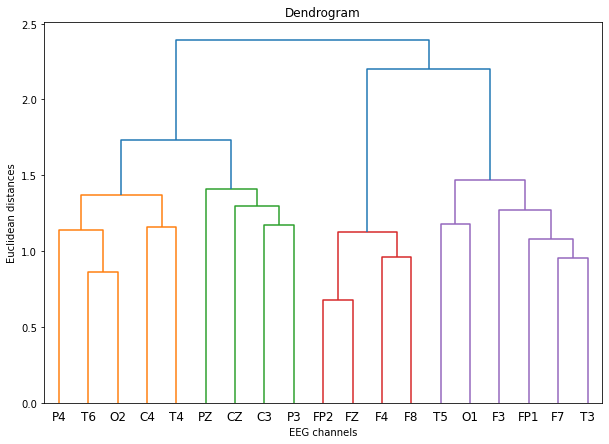

In [542]:
dendrogram_plt, linkage_data = plot_dendogram(normed_mi_matrix_epilepsy, channel_labels)
# plt.savefig('dendr_normed_mi_epilepsy.pdf', dpi=150, bbox_inches='tight')

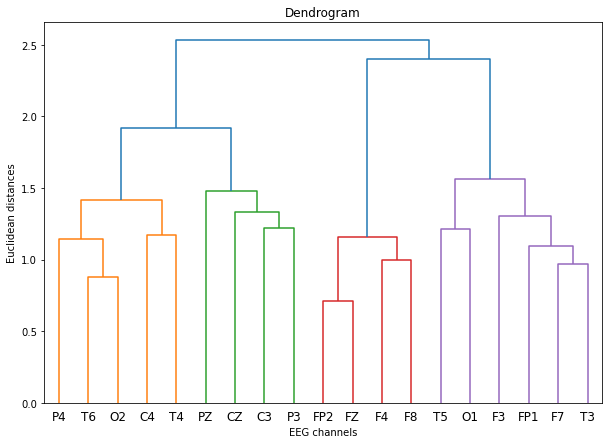

In [543]:
dendrogram_plt, linkage_data = plot_dendogram(proportional_thresholding(normed_mi_matrix_epilepsy, percentile=50), channel_labels)
# plt.savefig('dendr_normed_mi_epilepsy_prop_thresh_50pct.pdf', dpi=150, bbox_inches='tight')

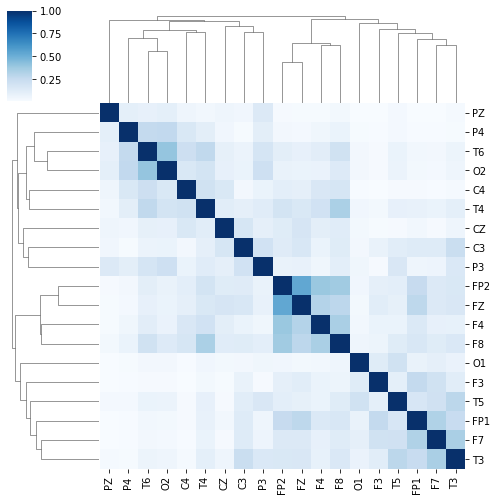

In [19]:
mi_df = pd.DataFrame(normed_mi_matrix_epilepsy, columns=channel_labels, index=channel_labels)
fg = sns.clustermap(mi_df,  cmap="Blues", figsize=(7,7))
# plt.savefig('clustermap_normed_mi_epilepsy.pdf', dpi=150, bbox_inches='tight')

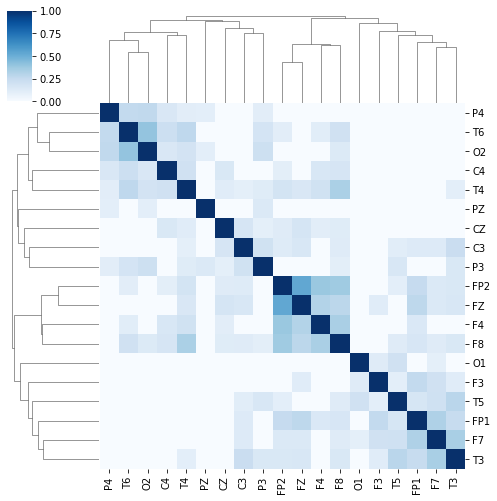

In [611]:
mi_df = pd.DataFrame(proportional_thresholding(normed_mi_matrix_epilepsy, percentile=50),
                columns=channel_labels, index=channel_labels)
fg = sns.clustermap(mi_df,  cmap="Blues", figsize=(7,7))
# plt.savefig('clustermap_normed_mi_epilepsy_prop_th_50pct.pdf', dpi=150, bbox_inches='tight')

In [32]:
# read edf file from filename
df, channel_labels = read_edf_to_pandas(edf_file_no_epilepsy)
mi_matrix_no_epilepsy = compute_mi_matrix(df)
# calculate the mutual information matrix
normed_mi_matrix_no_epilepsy = compute_normed_mi_matrix(mi_matrix_no_epilepsy)

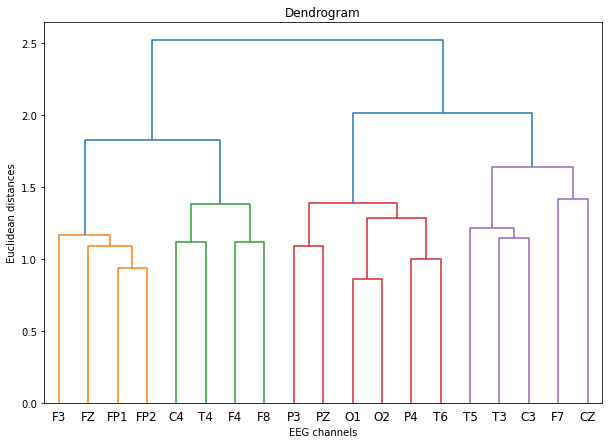

In [605]:
dendrogram_plt, linkage_data = plot_dendogram(normed_mi_matrix_no_epilepsy, channel_labels)
# plt.savefig('dendr_normed_mi_no_epilepsy.pdf', dpi=150, bbox_inches='tight')

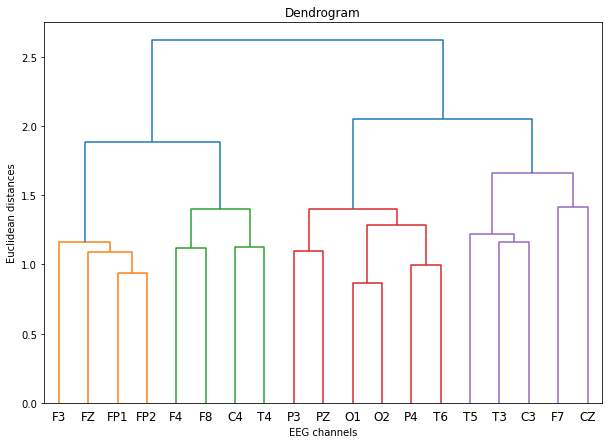

In [550]:
dendrogram_plt, linkage_data = plot_dendogram(proportional_thresholding(normed_mi_matrix_no_epilepsy, percentile=50), channel_labels)
# plt.savefig('dendr_normed_mi_no_epilepsy_prop_thresh_50pct.pdf', dpi=150, bbox_inches='tight')

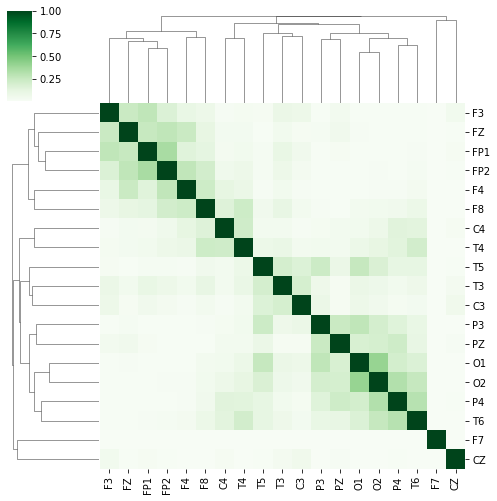

In [22]:
mi_df = pd.DataFrame(normed_mi_matrix_no_epilepsy, columns=channel_labels, index=channel_labels)
fg = sns.clustermap(mi_df,  cmap="Greens", figsize=(7,7))
# plt.savefig('clustermap_normed_mi_no_epilepsy.pdf', dpi=150, bbox_inches='tight')

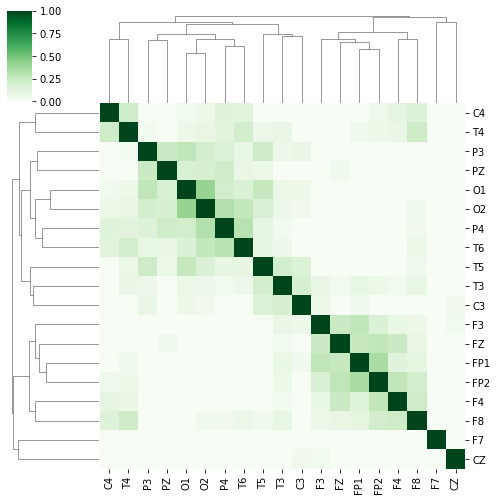

In [612]:
mi_df = pd.DataFrame(proportional_thresholding(normed_mi_matrix_no_epilepsy, percentile=50),
                columns=channel_labels, index=channel_labels)
fg = sns.clustermap(mi_df,  cmap="Greens", figsize=(7,7))
# plt.savefig('clustermap_normed_mi_no_epilepsy_prop_th_50pct.pdf', dpi=150, bbox_inches='tight')

### 1.5.3 - Dendrograms and clustermaps for correlation matrices

In [551]:
# read edf file from filename
df, channel_labels = read_edf_to_pandas(edf_file_epilepsy)

# calculate the mutual information matrix
cor_matrix_epilepsy = compute_corr_matrix(edf_file_epilepsy)

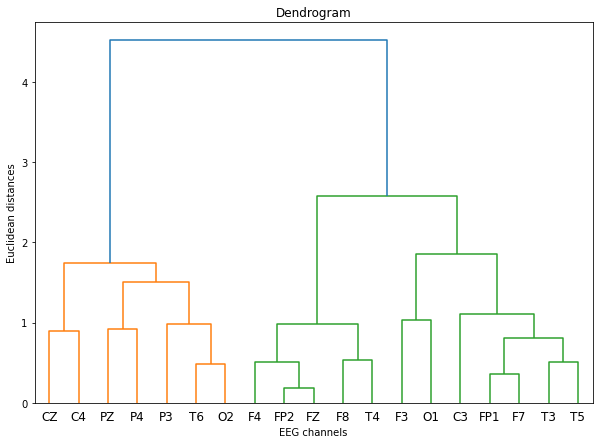

In [553]:
dendrogram_plt, linkage_data = plot_dendogram(cor_matrix_epilepsy, channel_labels)
# plt.savefig('dendr_corr_epilepsy.pdf', dpi=150, bbox_inches='tight')

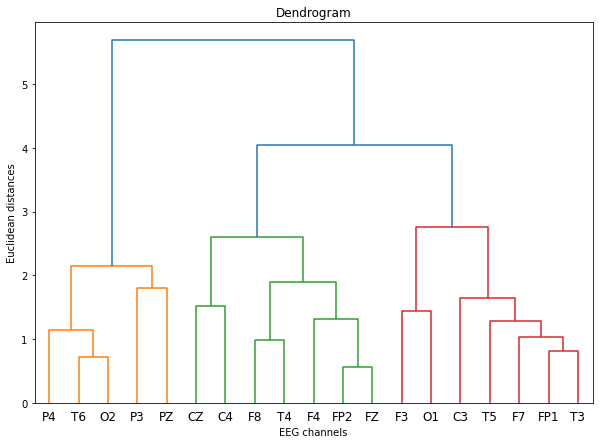

In [554]:
dendrogram_plt, linkage_data = plot_dendogram(proportional_thresholding(cor_matrix_epilepsy, percentile=50), channel_labels)
# plt.savefig('dendr_corr_epilepsy_prop_thresh_50pct.pdf', dpi=150, bbox_inches='tight')

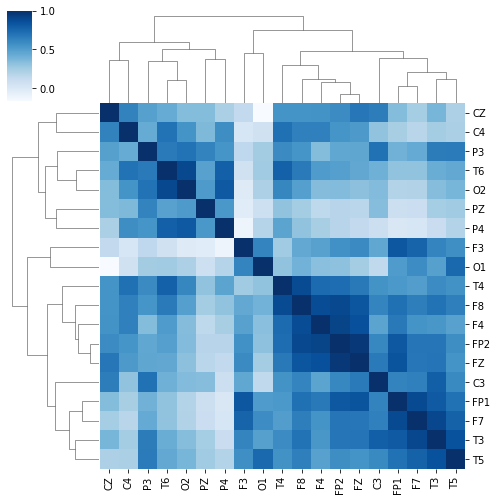

In [25]:
mi_df = pd.DataFrame(cor_matrix_epilepsy, columns=channel_labels, index=channel_labels)
fg = sns.clustermap(mi_df,  cmap="Blues", figsize=(7,7))
# plt.savefig('clustermap_corr_mi_epilepsy.pdf', dpi=150, bbox_inches='tight')

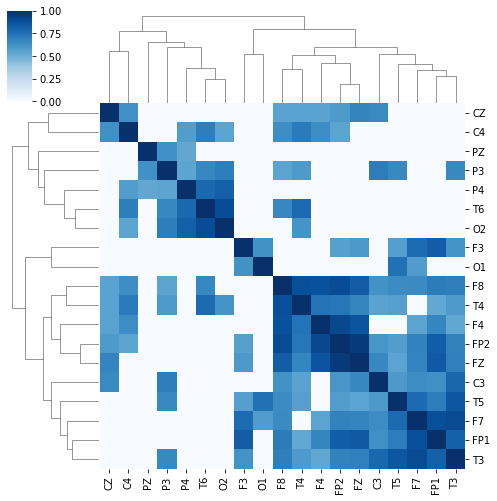

In [613]:
mi_df = pd.DataFrame(proportional_thresholding(cor_matrix_epilepsy, percentile=50),
                columns=channel_labels, index=channel_labels)
fg = sns.clustermap(mi_df,  cmap="Blues", figsize=(7,7))
# plt.savefig('clustermap_corr_epilepsy_prop_th_50pct.pdf', dpi=150, bbox_inches='tight')

In [555]:
# read edf file from filename
df, channel_labels = read_edf_to_pandas(edf_file_no_epilepsy)

# calculate the mutual information matrix
cor_matrix_no_epilepsy = compute_corr_matrix(edf_file_no_epilepsy)

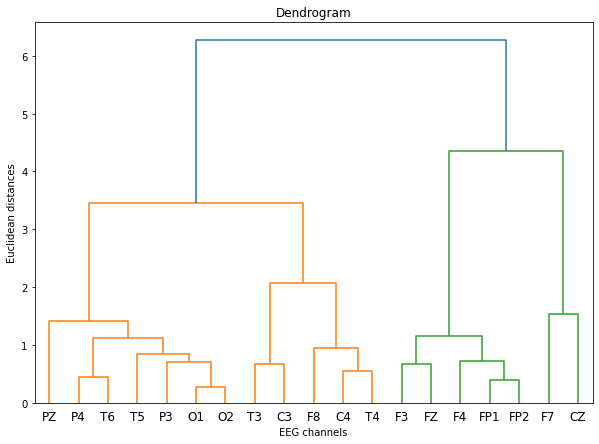

In [556]:
dendrogram_plt, linkage_data = plot_dendogram(cor_matrix_no_epilepsy, channel_labels)
# plt.savefig('dendr_corr_no_epilepsy.pdf', dpi=150, bbox_inches='tight')

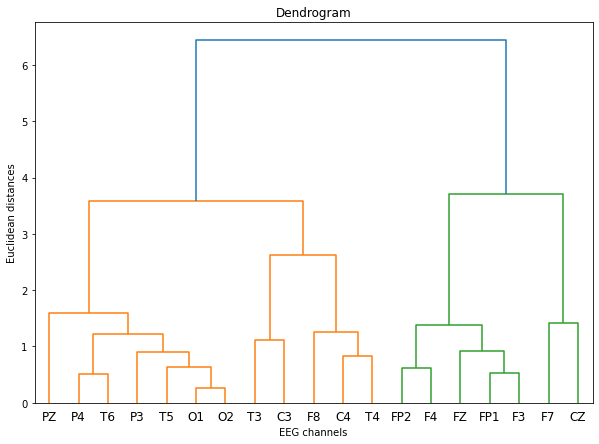

In [557]:
dendrogram_plt, linkage_data = plot_dendogram(proportional_thresholding(cor_matrix_no_epilepsy, percentile=50), channel_labels)
# plt.savefig('dendr_corr_no_epilepsy_prop_thresh_50pct.pdf', dpi=150, bbox_inches='tight')

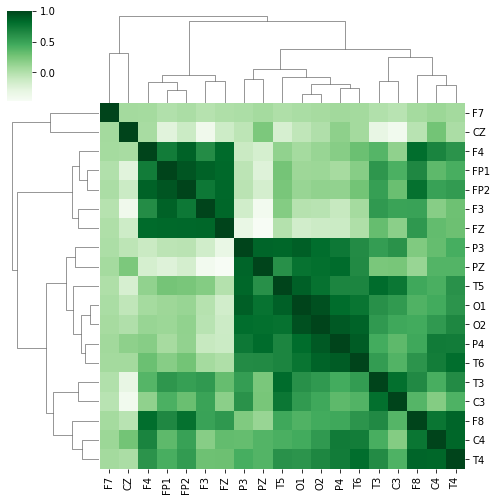

In [28]:
mi_df = pd.DataFrame(cor_matrix_no_epilepsy, columns=channel_labels, index=channel_labels)
fg = sns.clustermap(mi_df,  cmap="Greens", figsize=(7,7))
# plt.savefig('clustermap_corr_no_epilepsy.pdf', dpi=150, bbox_inches='tight')

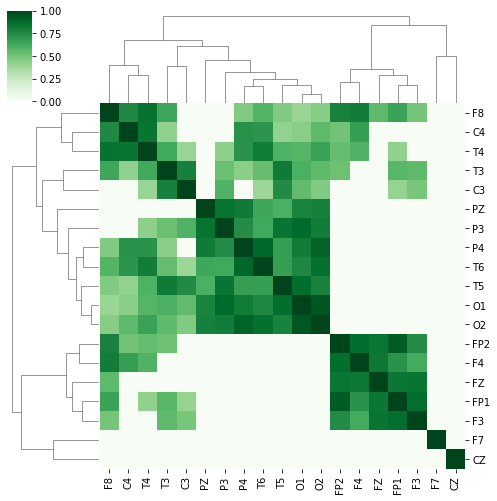

In [614]:
mi_df = pd.DataFrame(proportional_thresholding(cor_matrix_no_epilepsy, percentile=50),
                columns=channel_labels, index=channel_labels)
fg = sns.clustermap(mi_df,  cmap="Greens", figsize=(7,7))
# plt.savefig('clustermap_corr_no_epilepsy_prop_th_50pct.pdf', dpi=150, bbox_inches='tight')

## 1.6 - Graph representations based on computed matrices

![10-20 system](https://static-01.hindawi.com/articles/js/volume-2020/3083910/figures/3083910.fig.001.svgz)
<img src="https://www.vhv.rs/dpng/d/522-5220413_64-channel-eeg-cap-hd-png-download.png" alt="drawing" width="400"/>

In [33]:
# the TUEP database has 3 EEG channel configurations: '02_tcp_le', '03_tcp_ar_a', '01_tcp_ar'
# number of channels and channel names differ within these configurations
# to be able to compare the different EEG readings we need to select channels
# that are common for all configurations

# the list of channels (their short labels) that we will use for analysing EEG data
# labels are written in the left-to-right and top-down order, as presented in the figure
channels_to_use = ['FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8',
                   'T3', 'C3', 'CZ', 'C4', 'T4', 'T5', 'P3',
                   'PZ', 'P4', 'T6', 'O1', 'O2']

# the process of deducing these channels and labels is described below

In [34]:
# electrode positions for the graph nodes
# based on the international 10-20 system
node_positions = {'FP1': (-0.4, 0.45), 'FP2': (0.4, 0.45),
                  'F7': (-1.25, 0.33), 'F3': (-0.65, 0.255),
                  'FZ': (0.0, 0.225), 'F4': (0.65, 0.255),
                  'F8': (1.25, 0.33), 'T3': (-1.5, 0.0),
                  'C3': (-0.75, 0.0), 'CZ': (0.0, 0.0),
                  'C4': (0.75, 0.0), 'T4': (1.5, 0.0),
                  'T5': (-1.25, -0.33), 'P3': (-0.65, -0.255),
                  'PZ': (0.0, -0.225), 'P4': (0.65, -0.255),
                  'T6': (1.25, -0.33), 'O1': (-0.4, -0.45),
                  'O2': (0.4, -0.45) 
                 }

nodelist = node_positions.keys()

In [38]:
edge_colors = plt.cm.Blues
node_colors = 'red'

def plot_graph(G, ax, add_edge_labels=False):
    plt.figure(figsize=(7,7))

    # plot nodes
    nx.draw_networkx_nodes(G,
                           node_positions,
                           nodelist=nodelist,
                           node_size=800, 
                           node_color=node_colors,
                           alpha=0.7,
                           ax=ax)

    # plot node labels
    nx.draw_networkx_labels(G,
                            node_positions,
                            labels=dict(zip(nodelist, nodelist)),
                            font_color='white',
                            font_size=14,
                            font_weight='bold',
                            ax=ax
                           )
    
    edge_weights = nx.get_edge_attributes(G,'weight')
    
    # plot edges
    plt_graph_obj = nx.draw_networkx_edges(
        G, node_positions,
        edge_cmap=edge_colors,
        width=5,
        edge_color=[G[u][v]['weight'] for u, v in G.edges],
        ax=ax
    )
    
    # plot edge labels (weights)
    if add_edge_labels:
        edge_labels = nx.draw_networkx_edge_labels(
            G, node_positions,
            edge_labels=edge_weights,
            label_pos=0.5,
            ax=ax
        )
    
    # plt.box(False)
    # ax.axis('off')
    
    return edge_weights

### 1.6.1 - Functional connectivity graphs and MST plots for NOT normalized mutual information matrices

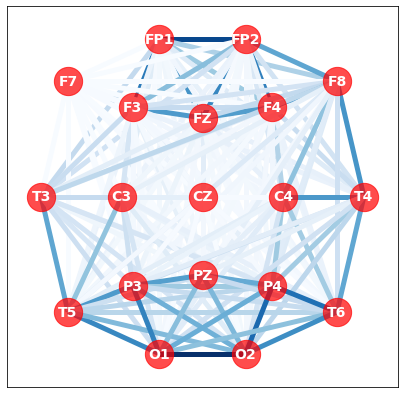

In [32]:
mi_df = pd.DataFrame(mi_matrix_no_epilepsy, columns=channel_labels, index=channel_labels)

# represent the adjacency matrix as an edge list
edge_list_df = mi_df.stack().reset_index()
edge_list_df.columns = ['from_node', 'to_node', 'weight']

# exclude 0-weight edges and self-edges 
graph_edges = edge_list_df.loc[(edge_list_df['weight']>0)&
                               (edge_list_df['from_node'] != edge_list_df['to_node'])
                                 ]
# create the graph
G=nx.from_pandas_edgelist(graph_edges , 'from_node', 'to_node', edge_attr='weight')
edge_weights = plot_graph(G, ax=None, add_edge_labels=False)

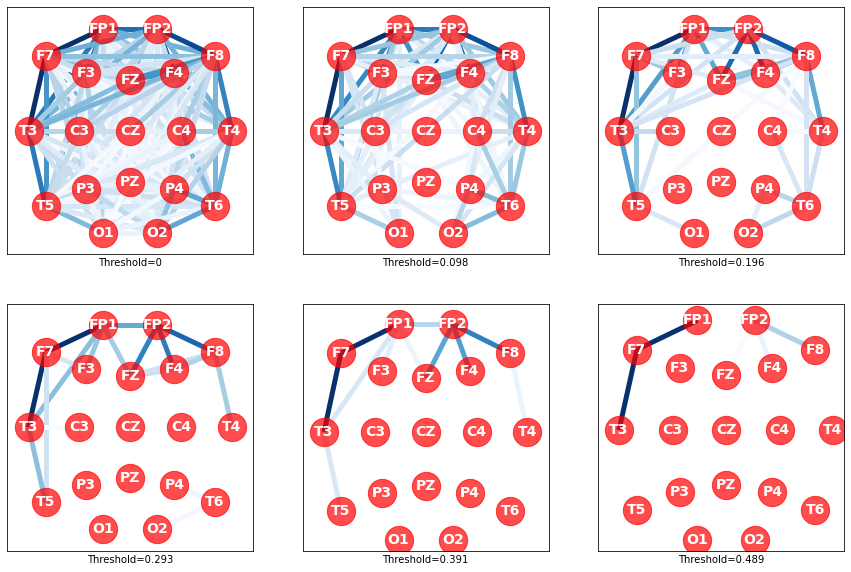

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

In [207]:
mi_df = pd.DataFrame(mi_matrix_epilepsy.round(5), columns=channel_labels, index=channel_labels)

# represent the adjacency matrix as an edge list
edge_list_df = mi_df.stack().reset_index()
edge_list_df.columns = ['from_node', 'to_node', 'weight']
thresholds = [0]+list(np.linspace(0, np.triu(mi_matrix_epilepsy, 1).round(5).max().max(), 6, endpoint=False)[1:])

fig, ax = plt.subplots(2,3, figsize=(15,10))
ax = ax.flatten()

for i, th in enumerate(thresholds):

  # exclude 0-weight edges and self-edges 
  graph_edges = edge_list_df.loc[(edge_list_df['weight']>th)&
                                (edge_list_df['from_node'] != edge_list_df['to_node'])
                                  ]
  # create the graph
  G=nx.from_pandas_edgelist(graph_edges , 'from_node', 'to_node', edge_attr='weight')
  edge_weights = plot_graph(G, ax=ax[i],add_edge_labels=False)
  ax[i].set_xlabel(f'Threshold={np.round(th,3)}')

# fig.savefig('fc_by_th_mi_epilepsy.pdf', dpi=150, bbox_inches='tight')

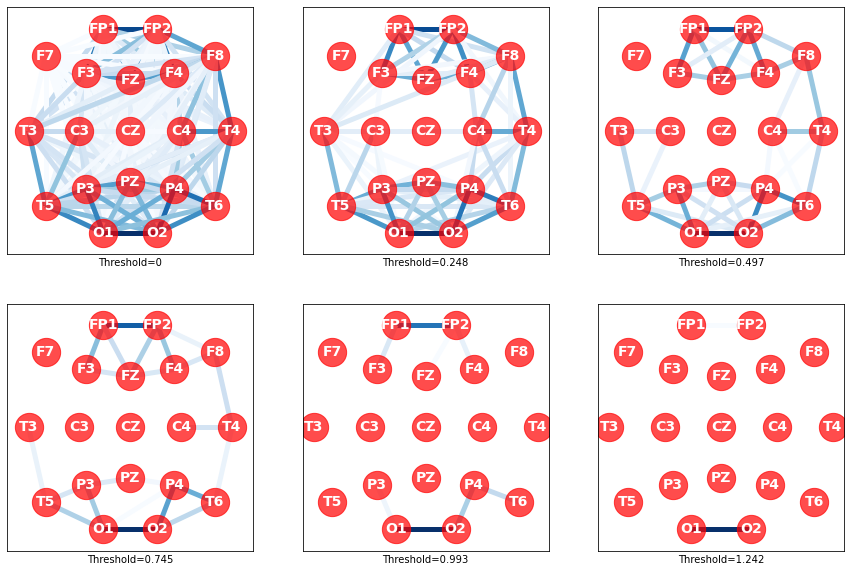

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

In [60]:
mi_df = pd.DataFrame(mi_matrix_no_epilepsy.round(5), columns=channel_labels, index=channel_labels)

# represent the adjacency matrix as an edge list
edge_list_df = mi_df.stack().reset_index()
edge_list_df.columns = ['from_node', 'to_node', 'weight']
thresholds = [0]+list(np.linspace(0, np.triu(mi_matrix_no_epilepsy, 1).round(5).max().max(), 6, endpoint=False)[1:])

fig, ax = plt.subplots(2,3, figsize=(15,10))
ax = ax.flatten()

for i, th in enumerate(thresholds):

  # exclude 0-weight edges and self-edges 
  graph_edges = edge_list_df.loc[(edge_list_df['weight']>th)&
                                (edge_list_df['from_node'] != edge_list_df['to_node'])
                                  ]
  # create the graph
  G=nx.from_pandas_edgelist(graph_edges , 'from_node', 'to_node', edge_attr='weight')
  edge_weights = plot_graph(G, ax=ax[i],add_edge_labels=False)
  ax[i].set_xlabel(f'Threshold={np.round(th,3)}')

# fig.savefig('fc_by_th_mi_no_epilepsy.pdf', dpi=150, bbox_inches='tight')

### 1.6.2 - Functional connectivity graphs and MST plots for normalized mutual information matrices

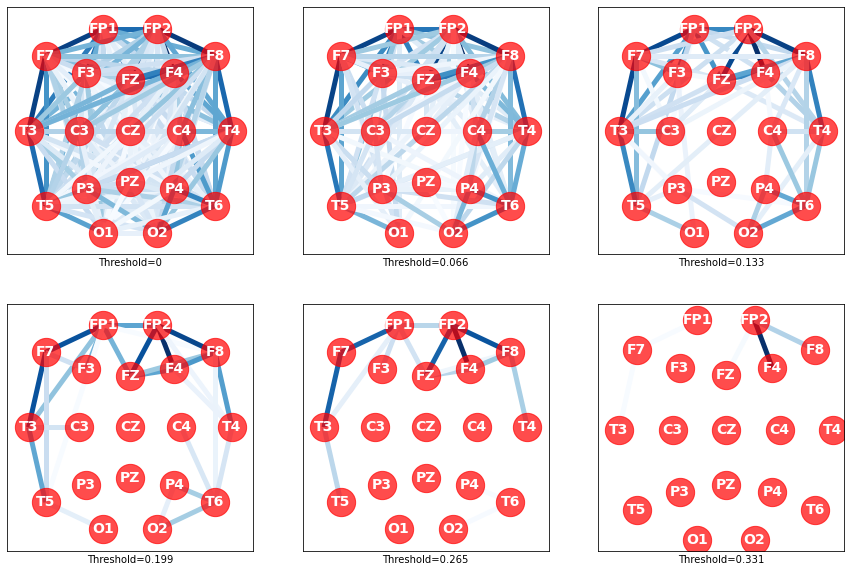

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

In [224]:
mi_df = pd.DataFrame(normed_mi_matrix_epilepsy.round(5), columns=channel_labels, index=channel_labels)

# represent the adjacency matrix as an edge list
edge_list_df = mi_df.stack().reset_index()
edge_list_df.columns = ['from_node', 'to_node', 'weight']
thresholds = [0]+list(np.linspace(0, np.triu(normed_mi_matrix_epilepsy, 1).round(5).max().max(), 6, endpoint=False)[1:])

fig, ax = plt.subplots(2,3, figsize=(15,10))
ax = ax.flatten()

for i, th in enumerate(thresholds):

  # exclude 0-weight edges and self-edges 
  graph_edges = edge_list_df.loc[(edge_list_df['weight']>th)&
                                (edge_list_df['from_node'] != edge_list_df['to_node'])
                                  ]
  # create the graph
  G=nx.from_pandas_edgelist(graph_edges , 'from_node', 'to_node', edge_attr='weight')
  edge_weights = plot_graph(G, ax=ax[i],add_edge_labels=False)
  ax[i].set_xlabel(f'Threshold={np.round(th,3)}')

# fig.savefig('fc_by_th_normed_mi_epilepsy.pdf', dpi=150, bbox_inches='tight')

### Proportional thresholding effects on the functional connectivity graphs.

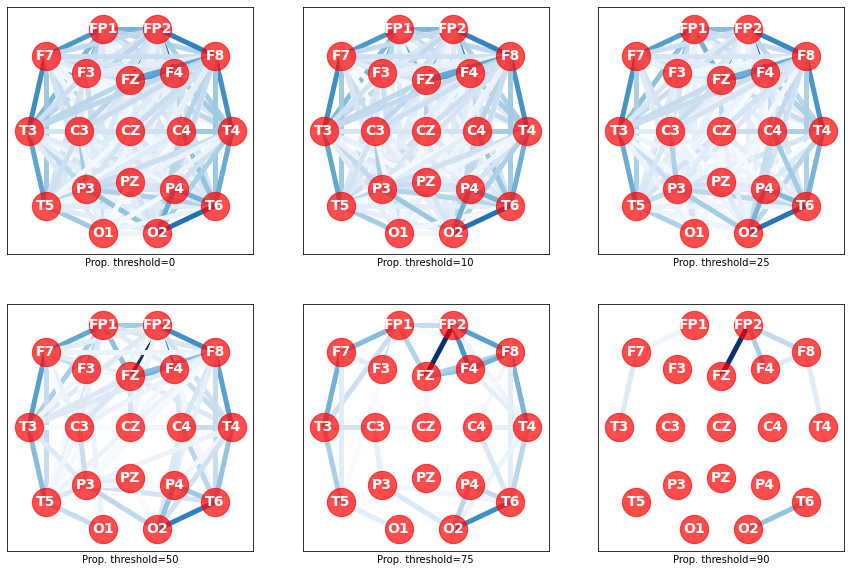

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

In [562]:

prop_thresholds = [0, 10, 25, 50, 75, 90]

fig, ax = plt.subplots(2,3, figsize=(15,10))
ax = ax.flatten()

for i, th in enumerate(prop_thresholds):
  mi_df = pd.DataFrame(proportional_thresholding(normed_mi_matrix_epilepsy.round(5), percentile=th),
                       columns=channel_labels, index=channel_labels)

  # represent the adjacency matrix as an edge list
  edge_list_df = mi_df.stack().reset_index()
  edge_list_df.columns = ['from_node', 'to_node', 'weight']
  # exclude 0-weight edges and self-edges 
  graph_edges = edge_list_df.loc[(edge_list_df['weight']>0)&
                                (edge_list_df['from_node'] != edge_list_df['to_node'])
                                  ]
  # create the graph
  G=nx.from_pandas_edgelist(graph_edges , 'from_node', 'to_node', edge_attr='weight')
  edge_weights = plot_graph(G, ax=ax[i],add_edge_labels=False)
  ax[i].set_xlabel(f'Prop. threshold={np.round(th,3)}')

# fig.savefig('fc_by_prop_th_normed_mi_epilepsy.pdf', dpi=150, bbox_inches='tight')

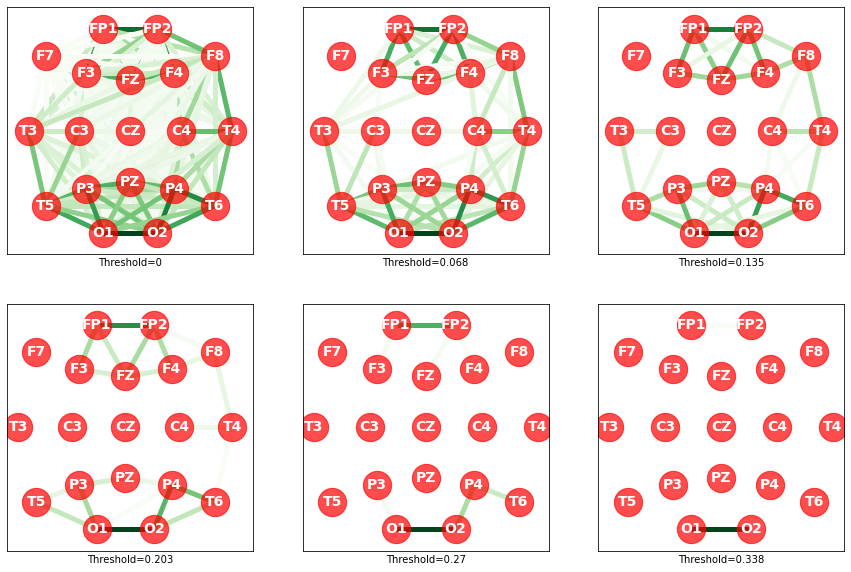

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

In [568]:
mi_df = pd.DataFrame(normed_mi_matrix_no_epilepsy.round(5), columns=channel_labels, index=channel_labels)

# represent the adjacency matrix as an edge list
edge_list_df = mi_df.stack().reset_index()
edge_list_df.columns = ['from_node', 'to_node', 'weight']
thresholds = [0]+list(np.linspace(0, np.triu(normed_mi_matrix_no_epilepsy, 1).round(5).max().max(), 6, endpoint=False)[1:])

fig, ax = plt.subplots(2,3, figsize=(15,10))
ax = ax.flatten()

for i, th in enumerate(thresholds):

  # exclude 0-weight edges and self-edges 
  graph_edges = edge_list_df.loc[(edge_list_df['weight']>th)&
                                (edge_list_df['from_node'] != edge_list_df['to_node'])
                                  ]
  # create the graph
  G=nx.from_pandas_edgelist(graph_edges , 'from_node', 'to_node', edge_attr='weight')
  edge_colors = plt.cm.Greens
  edge_weights = plot_graph(G, ax=ax[i],add_edge_labels=False)
  ax[i].set_xlabel(f'Threshold={np.round(th,3)}')

# fig.savefig('fc_by_th_normed_mi_no_epilepsy.pdf', dpi=150, bbox_inches='tight')

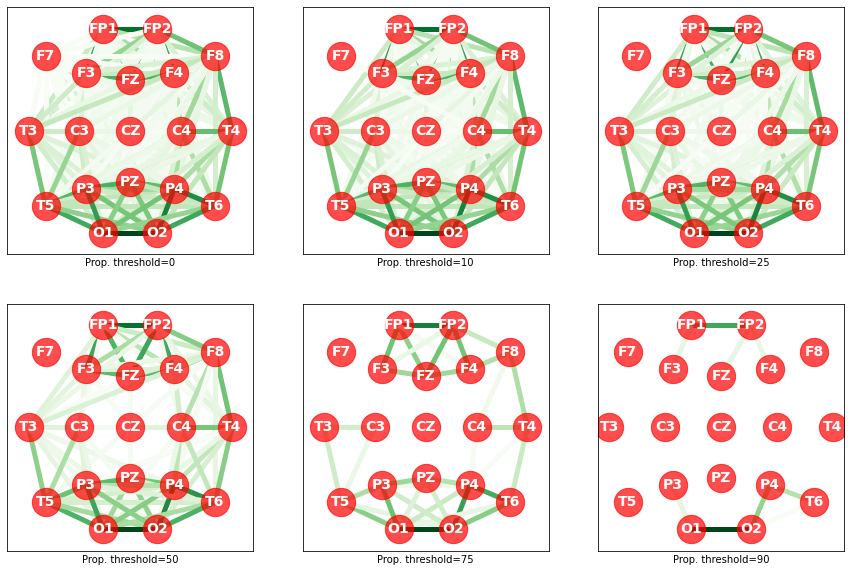

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

In [753]:
prop_thresholds = [0, 10, 25, 50, 75, 90]

fig, ax = plt.subplots(2,3, figsize=(15,10))
ax = ax.flatten()

for i, th in enumerate(prop_thresholds):
  mi_df = pd.DataFrame(proportional_thresholding(normed_mi_matrix_no_epilepsy.round(5), percentile=th),
                       columns=channel_labels, index=channel_labels)

  # represent the adjacency matrix as an edge list
  edge_list_df = mi_df.stack().reset_index()
  edge_list_df.columns = ['from_node', 'to_node', 'weight']
  # exclude 0-weight edges and self-edges 
  graph_edges = edge_list_df.loc[(edge_list_df['weight']>0)&
                                (edge_list_df['from_node'] != edge_list_df['to_node'])
                                  ]
  # create the graph
  G=nx.from_pandas_edgelist(graph_edges , 'from_node', 'to_node', edge_attr='weight')
  edge_colors = plt.cm.Greens
  edge_weights = plot_graph(G, ax=ax[i],add_edge_labels=False)
  ax[i].set_xlabel(f'Prop. threshold={np.round(th,3)}')

# fig.savefig('fc_by_prop_th_normed_mi_no_epilepsy.pdf', dpi=150, bbox_inches='tight')

### 1.6.3 - Functional connectivity graphs and MST plots for correlation matrix

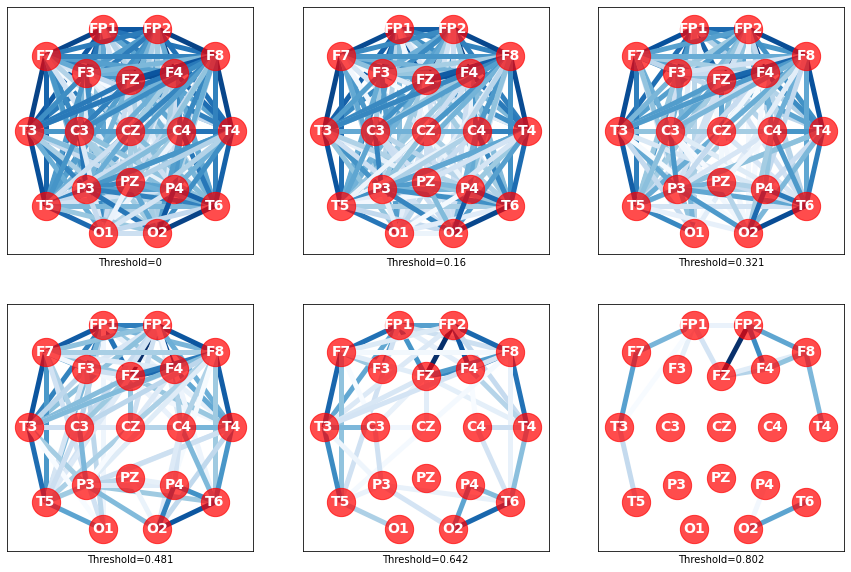

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

In [227]:
mi_df = pd.DataFrame(cor_matrix_epilepsy.round(5), columns=channel_labels, index=channel_labels)

# represent the adjacency matrix as an edge list
edge_list_df = mi_df.stack().reset_index()
edge_list_df.columns = ['from_node', 'to_node', 'weight']
thresholds = [0]+list(np.linspace(0, np.triu(cor_matrix_epilepsy, 1).round(5).max().max(), 6, endpoint=False)[1:])

fig, ax = plt.subplots(2,3, figsize=(15,10))
ax = ax.flatten()

for i, th in enumerate(thresholds):

  # exclude 0-weight edges and self-edges 
  graph_edges = edge_list_df.loc[(edge_list_df['weight']>th)&
                                (edge_list_df['from_node'] != edge_list_df['to_node'])
                                  ]
  # create the graph
  G=nx.from_pandas_edgelist(graph_edges , 'from_node', 'to_node', edge_attr='weight')
  edge_weights = plot_graph(G, ax=ax[i],add_edge_labels=False)
  ax[i].set_xlabel(f'Threshold={np.round(th,3)}')

# fig.savefig('fc_by_th_corr_epilepsy.pdf', dpi=150, bbox_inches='tight')

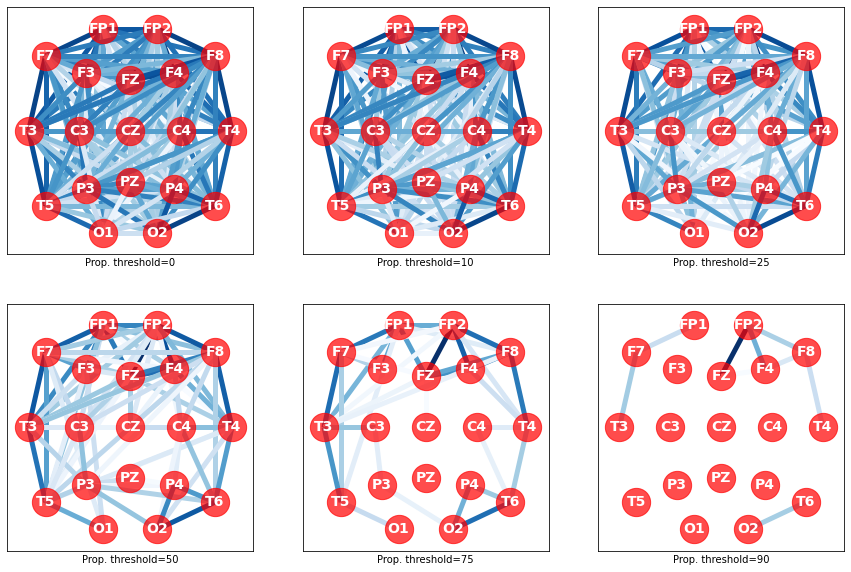

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

In [571]:

prop_thresholds = [0, 10, 25, 50, 75, 90]

fig, ax = plt.subplots(2,3, figsize=(15,10))
ax = ax.flatten()

for i, th in enumerate(prop_thresholds):
  mi_df = pd.DataFrame(proportional_thresholding(cor_matrix_epilepsy.round(5), percentile=th),
                       columns=channel_labels, index=channel_labels)

  # represent the adjacency matrix as an edge list
  edge_list_df = mi_df.stack().reset_index()
  edge_list_df.columns = ['from_node', 'to_node', 'weight']
  # exclude 0-weight edges and self-edges 
  graph_edges = edge_list_df.loc[(edge_list_df['weight']>0)&
                                (edge_list_df['from_node'] != edge_list_df['to_node'])
                                  ]
  # create the graph
  G=nx.from_pandas_edgelist(graph_edges , 'from_node', 'to_node', edge_attr='weight')
  edge_colors = plt.cm.Blues
  edge_weights = plot_graph(G, ax=ax[i],add_edge_labels=False)
  ax[i].set_xlabel(f'Prop. threshold={np.round(th,3)}')


# fig.savefig('fc_by_prop_th_corr_epilepsy.pdf', dpi=150, bbox_inches='tight')

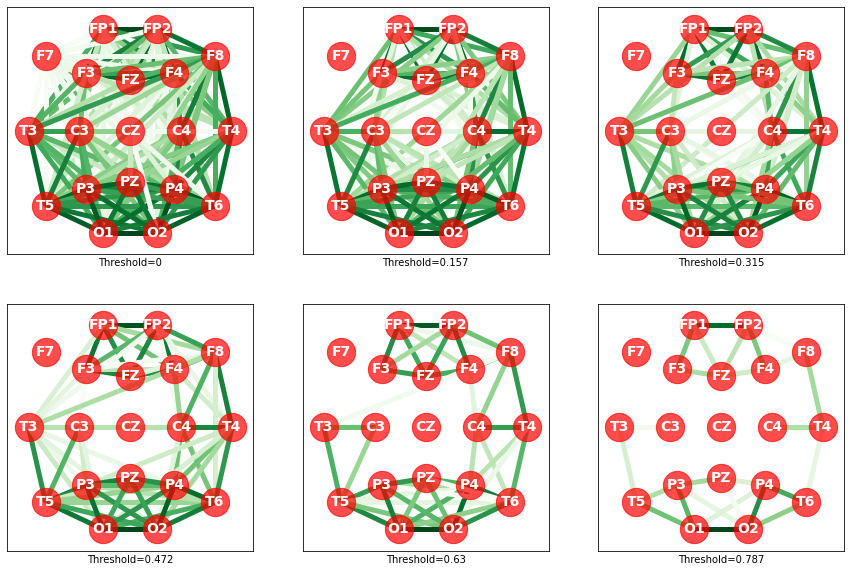

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

In [606]:
mi_df = pd.DataFrame(cor_matrix_no_epilepsy.round(5), columns=channel_labels, index=channel_labels)

# represent the adjacency matrix as an edge list
edge_list_df = mi_df.stack().reset_index()
edge_list_df.columns = ['from_node', 'to_node', 'weight']
thresholds = [0]+list(np.linspace(0, np.triu(cor_matrix_no_epilepsy, 1).round(5).max().max(), 6, endpoint=False)[1:])

fig, ax = plt.subplots(2,3, figsize=(15,10))
ax = ax.flatten()

for i, th in enumerate(thresholds):

  # exclude 0-weight edges and self-edges 
  graph_edges = edge_list_df.loc[(edge_list_df['weight']>th)&
                                (edge_list_df['from_node'] != edge_list_df['to_node'])
                                  ]
  # create the graph
  G=nx.from_pandas_edgelist(graph_edges , 'from_node', 'to_node', edge_attr='weight')
  edge_colors = plt.cm.Greens
  edge_weights = plot_graph(G, ax=ax[i],add_edge_labels=False)
  ax[i].set_xlabel(f'Threshold={np.round(th,3)}')

# fig.savefig('fc_by_th_corr_no_epilepsy.pdf', dpi=150, bbox_inches='tight')

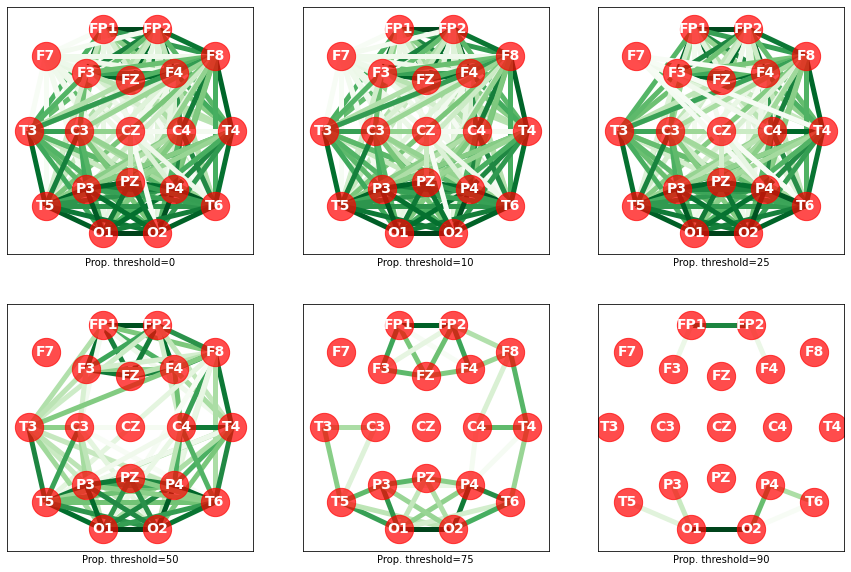

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

In [574]:

prop_thresholds = [0, 10, 25, 50, 75, 90]

fig, ax = plt.subplots(2,3, figsize=(15,10))
ax = ax.flatten()

for i, th in enumerate(prop_thresholds):
  mi_df = pd.DataFrame(proportional_thresholding(cor_matrix_no_epilepsy.round(5), percentile=th),
                       columns=channel_labels, index=channel_labels)

  # represent the adjacency matrix as an edge list
  edge_list_df = mi_df.stack().reset_index()
  edge_list_df.columns = ['from_node', 'to_node', 'weight']
  # exclude 0-weight edges and self-edges 
  graph_edges = edge_list_df.loc[(edge_list_df['weight']>0)&
                                (edge_list_df['from_node'] != edge_list_df['to_node'])
                                  ]
  # create the graph
  G=nx.from_pandas_edgelist(graph_edges , 'from_node', 'to_node', edge_attr='weight')
  edge_colors = plt.cm.Greens
  edge_weights = plot_graph(G, ax=ax[i],add_edge_labels=False)
  ax[i].set_xlabel(f'Prop. threshold={np.round(th,3)}')


# fig.savefig('fc_by_prop_th_corr_no_epilepsy.pdf', dpi=150, bbox_inches='tight')

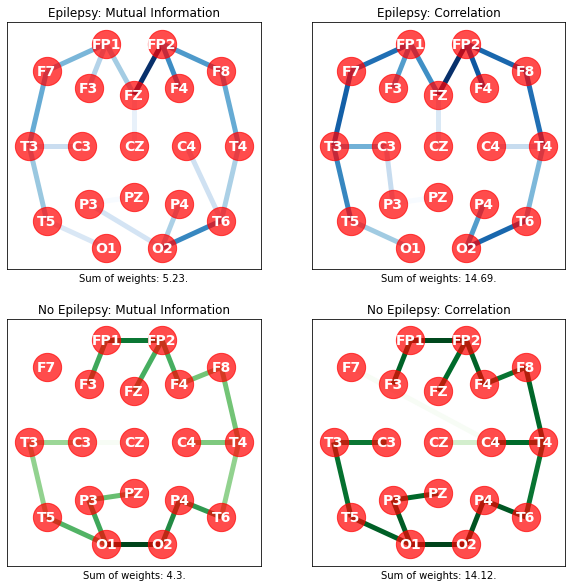

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

In [602]:
# xlabels = ['MI Epilepcy', 'NMI Epilepcy', 'Corr Epilepcy',
#           'MI No Epilepcy','NMI No Epilepcy', 'Corr No Epilepcy']

xlabels = ['Epilepsy: Mutual Information', 'Epilepsy: Correlation',
           'No Epilepsy: Mutual Information', 'No Epilepsy: Correlation']

# matrices = [mi_matrix_epilepsy, normed_mi_matrix_epilepsy, cor_matrix_epilepsy,
#            mi_matrix_no_epilepsy, normed_mi_matrix_no_epilepsy, cor_matrix_no_epilepsy]

matrices = [normed_mi_matrix_epilepsy, cor_matrix_epilepsy,
            normed_mi_matrix_no_epilepsy, cor_matrix_no_epilepsy]

l_edge_colors = [plt.cm.Blues, plt.cm.Blues, plt.cm.Greens, plt.cm.Greens]
node_colors = 'red'

fig, ax = plt.subplots(2,2, figsize=(10,10))
ax = ax.flatten()

for i, fc_mat in enumerate(matrices):
  mi_df = pd.DataFrame(fc_mat.round(2), columns=channel_labels, index=channel_labels)
  # represent the adjacency matrix as an edge list
  edge_list_df = mi_df.stack().reset_index()
  edge_list_df.columns = ['from_node', 'to_node', 'weight']
  # exclude 0-weight edges and self-edges 
  graph_edges = edge_list_df.loc[(edge_list_df['weight']>0)&
                                 (edge_list_df['from_node'] != edge_list_df['to_node'])
                                ]
  # create the graph
  G=nx.from_pandas_edgelist(graph_edges , 'from_node', 'to_node', edge_attr='weight')
  T = nx.maximum_spanning_tree(G)
  edge_colors = l_edge_colors[i]
  edge_weights = plot_graph(T, ax=ax[i], add_edge_labels=False)
  #print("Minimum spanning tree with maximum weight.")
  #print(f"Sum of weights: {np.sum(list(edge_weights.values())).round(3)}. ") 
  ax[i].set_title(xlabels[i])
  ax[i].set_xlabel(f"Sum of weights: {np.sum(list(edge_weights.values())).round(3)}.")

fig.savefig('pdfs/mst_graphs_normed_mi_corr.pdf', dpi=150, bbox_inches='tight')

# 3 - Visualize EEG data

Using matplotlib as 2D backend.
Opening raw-browser...


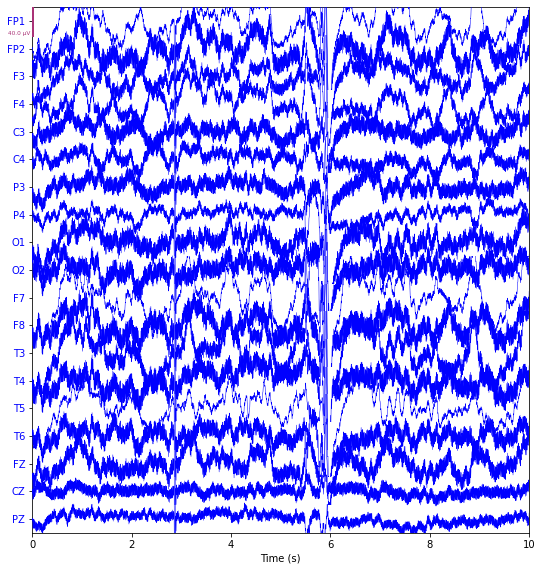

In [35]:
ch_name_update_func = lambda ch: ch.split(' ')[-1].split('-')[0]

raw_data_epilepsy = read_raw_edf(edf_file_epilepsy, verbose=False, preload=False)
raw_data_epilepsy.rename_channels(mapping=ch_name_update_func)
fig=raw_data_epilepsy.pick_channels(channels_to_use).plot(# duration=10,
                          n_channels=19, 
                          # title='No epilepsy',
                          color='blue',
                          show_scrollbars=False,
                         # show_scalebars=False
                         )
# fig.savefig('raw_eeg_data_epilepsy.pdf', dpi=150, bbox_inches='tight')

Opening raw-browser...


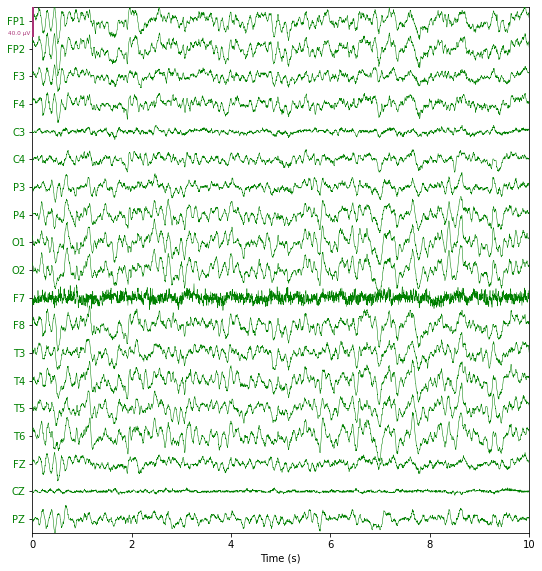

In [36]:
raw_data_no_epilepsy = read_raw_edf(edf_file_no_epilepsy, verbose=False, preload=False)
raw_data_no_epilepsy.rename_channels(mapping=ch_name_update_func)
fig = raw_data_no_epilepsy.pick_channels(channels_to_use).plot(# duration=10,
                          n_channels=19, 
                          # title='No epilepsy',
                          color='green',
                          show_scrollbars=False,
                         # show_scalebars=False
                         )
# fig.savefig('raw_eeg_data_no_epilepsy.pdf', dpi=150, bbox_inches='tight')

# 2 - Exploring EEG channels in the TUH EEG Epilepsy Corpus (TUEP)

In [37]:
# create a dataframe with overview over filenames in the TUEP
# there are 1648 files in the TUEP

df_files_overview = pd.DataFrame([f.split('/')[3:]+[f] for f in edf_file_list], 
            columns = ['text_label', 'ch_conf', '-', 'patient_id', 'session_date', 'filename', 'file_path'])

In [38]:
# create some additional columns

df_files_overview['session'] = df_files_overview['session_date'].apply(lambda s: s.split('_')[0])
df_files_overview['year'] = df_files_overview['session_date'].apply(lambda s: s.split('_')[1])
df_files_overview['month'] = df_files_overview['session_date'].apply(lambda s: s.split('_')[2])
df_files_overview['numeric_label'] = df_files_overview['text_label'].replace(to_replace=['epilepsy', 'no_epilepsy'], value=[1,0])
df_files_overview['token'] = df_files_overview['filename'].apply(lambda s: s.split('_')[-1][:-4])

In [39]:
df_files_overview.head(10)

text_label      ch_conf    - patient_id     session_date  \
0   epilepsy  03_tcp_ar_a  076   00007656  s010_2011_03_13   
1   epilepsy  03_tcp_ar_a  076   00007656  s010_2011_03_13   
2   epilepsy  03_tcp_ar_a  076   00007656  s010_2011_03_13   
3   epilepsy  03_tcp_ar_a  076   00007656  s010_2011_03_13   
4   epilepsy  03_tcp_ar_a  076   00007656  s010_2011_03_13   
5   epilepsy  03_tcp_ar_a  076   00007656  s010_2011_03_13   
6   epilepsy  03_tcp_ar_a  076   00007656  s006_2011_03_09   
7   epilepsy  03_tcp_ar_a  076   00007656  s006_2011_03_09   
8   epilepsy  03_tcp_ar_a  076   00007656  s006_2011_03_09   
9   epilepsy  03_tcp_ar_a  076   00007656  s006_2011_03_09   

                 filename                                          file_path  \
0  00007656_s010_t000.edf  ../tuh_eeg_epilepsy/edf/epilepsy/03_tcp_ar_a/0...   
1  00007656_s010_t001.edf  ../tuh_eeg_epilepsy/edf/epilepsy/03_tcp_ar_a/0...   
2  00007656_s010_t003.edf  ../tuh_eeg_epilepsy/edf/epilepsy/03_tcp_ar_a/0...   
3  00007656_s010_t002.edf  ../tuh_eeg_epilepsy/edf/epilepsy/03_tcp_ar_a/0...   
4  00007656_s010_t005.edf  ../tuh_eeg_epilepsy/edf/epilepsy/03_tcp_ar_a/0...   
5  00007656_s010_t004.edf  ../tuh_eeg_epilepsy/edf/epilepsy/03_tcp_ar_a/0...   
6  00007656_s006_t004.edf  ../tuh_eeg_epilepsy/edf/epilepsy/03_tcp_ar_a/0...   
7  00007656_s006_t000.edf  ../tuh_eeg_epilepsy/edf/epilepsy/03_tcp_ar_a/0...   
8  00007656_s006_t001.edf  ../tuh_eeg_epilepsy/edf/epilepsy/03_tcp_ar_a/0...   
9  00007656_s006_t003.edf  ../tuh_eeg_epilepsy/edf/epilepsy/03_tcp_ar_a/0...   

  session  year month  numeric_label token  
0    s010  2011    03              1  t000  
1    s010  2011    03              1  t001  
2    s010  2011    03              1  t003  
3    s010  2011    03              1  t002  
4    s010  2011    03              1  t005  
5    s010  2011    03              1  t004  
6    s006  2011    03              1  t004  
7    s006  2011    03              1  t000  
8    s006  2011    03              1  t001  
9    s006  2011    03              1  t003

In [44]:
df_files_overview['file_path'].nunique()

1648

In [45]:
df_files_overview['numeric_label'].value_counts()

1    1360
0     288
Name: numeric_label, dtype: int64

In [46]:
df_files_overview['patient_id'].nunique()

200

In [47]:
df_files_overview.groupby('numeric_label')['patient_id'].nunique()

numeric_label
0    100
1    100
Name: patient_id, dtype: int64

## 2.1 - Choosing common EEG channels for the 3 channel configurations

In [48]:
# there are 3 types of channel configurations in the TUEP

channel_configs = list(set([f.split('/')[4] for f in edf_file_list]))
print(channel_configs)

['03_tcp_ar_a', '01_tcp_ar', '02_tcp_le']


In [51]:
# get 3 files, one for each channel configuration
# to extract common channel labels

edf_files_ch_configs = [df_files_overview.query(f"ch_conf == '{ch_type}'")['file_path'].values[0] for ch_type in channel_configs]

In [52]:
edf_files_ch_configs

['../tuh_eeg_epilepsy/edf/epilepsy/03_tcp_ar_a/076/00007656/s010_2011_03_13/00007656_s010_t000.edf',
 '../tuh_eeg_epilepsy/edf/epilepsy/01_tcp_ar/104/00010412/s001_2013_03_12/00010412_s001_t000.edf',
 '../tuh_eeg_epilepsy/edf/epilepsy/02_tcp_le/023/00002309/s002_2010_02_15/00002309_s002_t000.edf']

In [53]:
# extract channel names from each configuration 
# in addition, get a short label from extracted channel name

ch_config_ch_names = {}

for filename in edf_files_ch_configs:
    raw_data = read_raw_edf(filename, verbose=False, preload=False)
    
    ch_conf = filename.split('/')[4] # ex. '03_tcp_ar_a'
    
    ch_config_ch_names[ch_conf] = raw_data.info["ch_names"] # ex. 'EEG FP1-REF'
    
    ch_config_ch_names[ch_conf+'_trim'] = [ch.split(' ')[-1].split('-')[0] for ch in raw_data.info["ch_names"]] # ex. 'FP1'

In [54]:
print('02_tcp_le_trim : \n', sorted(ch_config_ch_names['02_tcp_le_trim']))
print('01_tcp_ar_trim : \n', sorted(ch_config_ch_names['01_tcp_ar_trim']))
print('03_tcp_ar_a_trim : \n', sorted(ch_config_ch_names['03_tcp_ar_a_trim']))

02_tcp_le_trim : 
 ['26', '27', '28', '29', '30', '31', '32', 'A1', 'A2', 'C3', 'C4', 'CZ', 'DC1', 'DC2', 'DC3', 'DC4', 'DC5', 'DC6', 'DC7', 'DC8', 'EKG', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'O1', 'O2', 'OZ', 'P3', 'P4', 'PG1', 'PG2', 'PH', 'PZ', 'T3', 'T4', 'T5', 'T6']
01_tcp_ar_trim : 
 ['26', '27', '28', '29', '30', 'A1', 'A2', 'BURSTS', 'C3', 'C4', 'CZ', 'EKG1', 'EMG', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'IBI', 'LOC', 'O1', 'O2', 'P3', 'P4', 'PHOTIC', 'PZ', 'ROC', 'SUPPR', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6']
03_tcp_ar_a_trim : 
 ['29', '30', '31', '32', 'BURSTS', 'C3', 'C3P', 'C4', 'C4P', 'CZ', 'EKG1', 'EMG', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'IBI', 'O1', 'O2', 'P3', 'P4', 'PZ', 'SP1', 'SP2', 'SUPPR', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6']


In [55]:
# number of channels in each configuration

for k in ch_config_ch_names.keys():
    print(f"{k}': {len(ch_config_ch_names[k])}")

03_tcp_ar_a': 34
03_tcp_ar_a_trim': 34
01_tcp_ar': 36
01_tcp_ar_trim': 36
02_tcp_le': 41
02_tcp_le_trim': 41


## 2.3 - Function to Update Channel Names in EDF Files

In [125]:
# the function to update channel names from original to new format:
# 'C3', 'C4', 'CZ', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'O1', 'O2', 'P3', 'P4', 'PZ', 'T3', 'T4', 'T5', 'T6'
ch_name_update_func = lambda ch: ch.split(' ')[-1].split('-')[0]

# renaming the original channel names in one .edf file;
# the update will be written into the in-memory edf object
raw_data_no_epilepsy.rename_channels(mapping=ch_name_update_func)

<RawEDF | 00007671_s002_t002.edf, 32 x 182000 (455.0 s), ~34 kB, data not loaded>

In [70]:
# updated channel names
print(raw_data_no_epilepsy.info["ch_names"])

['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'FZ', 'CZ', 'PZ', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32']


## 2.4 - Select Common Channels in EDF Files

In [86]:
# after renaming the channel names we can select the common channels
# with the '.pick_channels()' method

# we must be careful with the order of channels in the file when 
# creating a dataframe from with EEG data

# here, we read 10 values from each channel into a dataframe and give correct column names
pd.DataFrame(raw_data_no_epilepsy.pick_channels(channels_to_use).get_data().T[:10,:],
            columns=raw_data_no_epilepsy.pick_channels(channels_to_use).info['ch_names'])

FP1       FP2        F3        F4            C3            C4  \
0  0.000008  0.000008  0.000005  0.000003 -1.789561e-06 -2.689342e-06   
1  0.000010  0.000009  0.000005  0.000004  1.000000e-08 -2.689342e-06   
2  0.000011  0.000009  0.000005  0.000003  1.000000e-08 -1.789561e-06   
3  0.000012  0.000009  0.000005  0.000004  1.000000e-08 -1.789561e-06   
4  0.000010  0.000010  0.000005  0.000005 -1.789561e-06 -1.789561e-06   
5  0.000011  0.000012  0.000005  0.000006 -1.789561e-06 -1.789561e-06   
6  0.000012  0.000012  0.000005  0.000008 -1.789561e-06  1.000000e-08   
7  0.000012  0.000010  0.000005  0.000008 -2.689342e-06 -8.897806e-07   
8  0.000012  0.000011  0.000006  0.000008 -1.789561e-06  1.000000e-08   
9  0.000012  0.000011  0.000005  0.000008 -2.689342e-06  1.000000e-08   

             P3            P4            O1            O2        F7  \
0 -1.789561e-06  2.709342e-06  8.108025e-06  9.907586e-06 -0.000006   
1 -1.789561e-06  9.097806e-07  7.208245e-06  9.007806e-06 -0.000010   
2 -8.897806e-07  9.097806e-07  6.308464e-06  9.007806e-06 -0.000010   
3 -1.789561e-06  9.097806e-07  4.508903e-06  6.308464e-06 -0.000010   
4 -4.488903e-06  9.097806e-07  9.097806e-07  6.308464e-06 -0.000008   
5 -4.488903e-06  9.097806e-07  9.097806e-07  5.408683e-06 -0.000015   
6 -3.589122e-06  9.097806e-07  9.097806e-07  4.508903e-06 -0.000013   
7 -4.488903e-06  9.097806e-07  1.000000e-08  4.508903e-06 -0.000009   
8 -4.488903e-06  9.097806e-07  1.000000e-08  1.809561e-06 -0.000006   
9 -5.388683e-06  1.000000e-08 -1.789561e-06  9.097806e-07 -0.000015   

             F8            T3            T4            T5        T6        FZ  \
0  2.709342e-06  4.508903e-06 -2.689342e-06  3.609122e-06  0.000007  0.000003   
1  9.097806e-07  5.408683e-06 -1.789561e-06  3.609122e-06  0.000008  0.000004   
2  4.508903e-06  6.308464e-06  1.000000e-08  3.609122e-06  0.000008  0.000004   
3  4.508903e-06  5.408683e-06 -8.897806e-07  9.097806e-07  0.000008  0.000003   
4  4.508903e-06  4.508903e-06  9.097806e-07  9.097806e-07  0.000008  0.000002   
5  8.108025e-06  4.508903e-06  1.809561e-06  1.000000e-08  0.000010  0.000002   
6  1.080737e-05  1.809561e-06  4.508903e-06 -1.789561e-06  0.000011  0.000003   
7  1.080737e-05  3.609122e-06  4.508903e-06 -8.897806e-07  0.000011  0.000004   
8  9.007806e-06  3.609122e-06  4.508903e-06 -1.789561e-06  0.000008  0.000005   
9  9.007806e-06  9.097806e-07  3.609122e-06 -2.689342e-06  0.000007  0.000005   

             CZ            PZ  
0 -8.897806e-07 -8.897806e-07  
1 -8.897806e-07 -1.789561e-06  
2 -1.789561e-06 -1.789561e-06  
3 -1.789561e-06 -2.689342e-06  
4 -1.789561e-06 -1.789561e-06  
5 -1.789561e-06 -1.789561e-06  
6 -1.789561e-06 -1.789561e-06  
7 -1.789561e-06 -1.789561e-06  
8 -1.789561e-06 -1.789561e-06  
9 -1.789561e-06 -3.589122e-06

## 2.5 - Plotting number of edges vs. threshold

In [40]:
def get_n_edges_by_thresholds(matrix, thresholds):
    """ Given a 19x19 symmetric matrix (e.g. correlation) and a list of thresholds,
        compute number of elements in the matrix that are greater than each threshold
        excluding the diagonal. These correspond to the number of edges in a FC graph.

        Return the list of  thresholds and computed numbers: thresholds_edges.
    """
    thresholds_edges = []

    for th in thresholds:
        n_ = np.sum(np.triu(np.abs(matrix)) > th)-19
        thresholds_edges.append([th, n_])
    
    return np.array(thresholds_edges)

### 2.5.1 - Plots based on NOT normalized mutual information matrices

In [ ]:
thresholds = np.arange(0, 1, 0.01)
thresholds_edges = get_n_edges_by_thresholds(cor_matrix_epilepsy, thresholds)
thresholds_edges_mi = get_n_edges_by_thresholds(mi_matrix_epilepsy, thresholds)
plt.plot(thresholds_edges[:,0],thresholds_edges[:,1], color='red')
plt.plot(thresholds_edges_mi[:,0],thresholds_edges_mi[:,1], color='blue')
plt.legend(['Correlation','Mutual Inf'])
plt.xlabel('thresholds')
plt.ylabel('N edges')
# plt.savefig('th_vs_edge_epilepsy.pdf', dpi=150, bbox_inches='tight')

Text(0, 0.5, 'N edges')

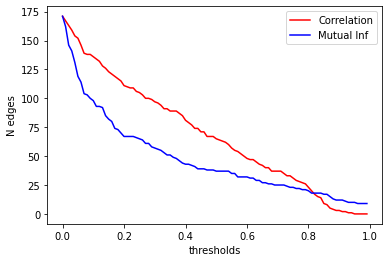

In [38]:
thresholds = np.arange(0, 1, 0.01)
thresholds_edges = get_n_edges_by_thresholds(cor_matrix_no_epilepsy, thresholds)
thresholds_edges_mi = get_n_edges_by_thresholds(mi_matrix_no_epilepsy, thresholds)
plt.plot(thresholds_edges[:,0],thresholds_edges[:,1], color='red')
plt.plot(thresholds_edges_mi[:,0],thresholds_edges_mi[:,1], color='blue')
plt.legend(['Correlation','Mutual Inf'])
plt.xlabel('thresholds')
plt.ylabel('N edges')
# plt.savefig('th_vs_edge_no_epilepsy.pdf', dpi=150, bbox_inches='tight')

### 2.5.2 - Plots based on normalized mutual information matrices

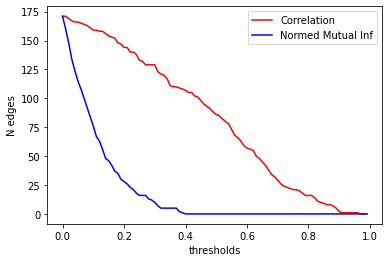

In [215]:
thresholds = np.arange(0, 1, 0.01)
thresholds_edges = get_n_edges_by_thresholds(cor_matrix_epilepsy, thresholds)
thresholds_edges_mi = get_n_edges_by_thresholds(normed_mi_matrix_epilepsy, thresholds)
plt.plot(thresholds_edges[:,0],thresholds_edges[:,1], color='red')
plt.plot(thresholds_edges_mi[:,0],thresholds_edges_mi[:,1], color='blue')
plt.legend(['Correlation','Normed Mutual Inf'])
plt.xlabel('thresholds')
plt.ylabel('N edges')
plt.savefig('th_vs_edge_normed_epilepsy.pdf', dpi=150, bbox_inches='tight')

Text(0, 0.5, 'N edges')

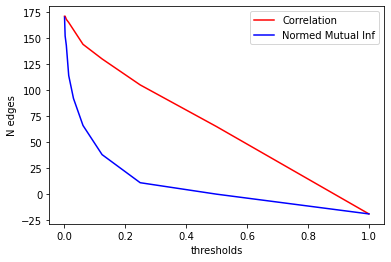

In [85]:
thresholds = np.arange(0, 1, 0.01)
thresholds = [pow(2, -i) for i in range(10)][1:][::-1]
thresholds = [pow(2, -i) for i in range(10)][::-1]
thresholds_edges = get_n_edges_by_thresholds(cor_matrix_no_epilepsy, thresholds)
thresholds_edges_mi = get_n_edges_by_thresholds(normed_mi_matrix_no_epilepsy, thresholds)
plt.plot(thresholds_edges[:,0],thresholds_edges[:,1], color='red')
plt.plot(thresholds_edges_mi[:,0],thresholds_edges_mi[:,1], color='blue')
plt.legend(['Correlation','Normed Mutual Inf'])
plt.xlabel('thresholds')
plt.ylabel('N edges')
# plt.savefig('th_vs_edge_normed_no_epilepsy.pdf', dpi=150, bbox_inches='tight')

### 2.5.3 - Combined plot based on normalized MI matrices

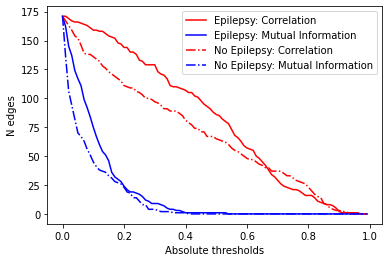

In [608]:
thresholds = np.arange(0, 1, 0.01)

thresholds_edges = get_n_edges_by_thresholds(cor_matrix_epilepsy, thresholds)
thresholds_edges_mi = get_n_edges_by_thresholds(normed_mi_matrix_epilepsy, thresholds)
plt.plot(thresholds_edges[:,0],thresholds_edges[:,1], color='red', ls='-')
plt.plot(thresholds_edges_mi[:,0],thresholds_edges_mi[:,1], color='blue', ls='-')

thresholds_edges = get_n_edges_by_thresholds(cor_matrix_no_epilepsy, thresholds)
thresholds_edges_mi = get_n_edges_by_thresholds(normed_mi_matrix_no_epilepsy, thresholds)
plt.plot(thresholds_edges[:,0],thresholds_edges[:,1], color='red', ls='-.')
plt.plot(thresholds_edges_mi[:,0],thresholds_edges_mi[:,1], color='blue', ls='-.')

plt.legend(['Epilepsy: Correlation','Epilepsy: Mutual Information',
            'No Epilepsy: Correlation','No Epilepsy: Mutual Information'])
plt.xlabel('Absolute thresholds')
plt.ylabel('N edges')
plt.savefig('pdfs/combined_th_vs_edge_normed_epilepsy.pdf', dpi=150, bbox_inches='tight')

### 2.5.4 - Combined loglog plot based on normalized MI matrices

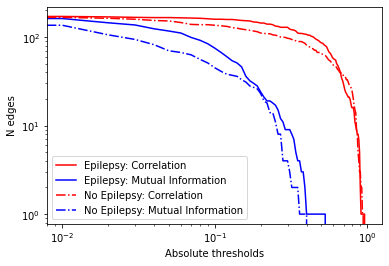

In [609]:
thresholds = np.arange(0, 1, 0.01)
thresholds_edges = get_n_edges_by_thresholds(cor_matrix_epilepsy, thresholds)
thresholds_edges_mi = get_n_edges_by_thresholds(normed_mi_matrix_epilepsy, thresholds)
plt.loglog(thresholds_edges[:,0],thresholds_edges[:,1], color='red', ls='-')
plt.loglog(thresholds_edges_mi[:,0],thresholds_edges_mi[:,1], color='blue', ls='-')

thresholds_edges = get_n_edges_by_thresholds(cor_matrix_no_epilepsy, thresholds)
thresholds_edges_mi = get_n_edges_by_thresholds(normed_mi_matrix_no_epilepsy, thresholds)
plt.loglog(thresholds_edges[:,0],thresholds_edges[:,1], color='red', ls='-.')
plt.loglog(thresholds_edges_mi[:,0],thresholds_edges_mi[:,1], color='blue', ls='-.')

plt.legend(['Epilepsy: Correlation','Epilepsy: Mutual Information',
            'No Epilepsy: Correlation','No Epilepsy: Mutual Information'], loc='lower left')
plt.xlabel('Absolute thresholds')
plt.ylabel('N edges')
plt.savefig('pdfs/combined_th_vs_edge_normed_epilepsy_loglog.pdf', dpi=150, bbox_inches='tight')

# 3. Saving matrices and MST edges/weights

In [41]:
# extract subject IDs from the file path, create python set to extract unique elements from list, convert to list again 
unique_epilepsy_patient_ids = list(set([x.split("/")[-1].split("_")[0] for x in edf_file_list]))
len(unique_epilepsy_patient_ids)

200

In [42]:
edf_files_per_patient = [df_files_overview.query(f"patient_id == '{id}'")['file_path'].values[0] for id in unique_epilepsy_patient_ids]
df_files_per_patient = df_files_overview[df_files_overview['file_path'].isin(edf_files_per_patient)]
chosen_files=[f for f in edf_files_per_patient if '/epilepsy/' in f] + [f for f in edf_files_per_patient if 'no_epilepsy' in f]

In [ ]:
from tqdm import tqdm

# store normed MI matrices into a dictionary with edf filename as a key

dict_edf_file_mi_matrix = {}

for i, edf_file in enumerate(tqdm(chosen_files)):
    df, ch = read_edf_to_pandas(edf_file)
    mi_matrix = compute_mi_matrix(df=df)
    dict_edf_file_mi_matrix[edf_file] = mi_matrix
    if i%10==0:
        print(i)

In [24]:
# save the obtained dictionary into a file using joblib
import joblib

# joblib.dump(dict_edf_file_mi_matrix, './matrices/mi_matrices_v0.data')

In [112]:
# loading the dictionary with MI matrices from a file

# dict_edf_file_mi_matrix = joblib.load('./matrices/mi_matrices_v0.data')

In [118]:
from tqdm import tqdm

# store normed MI matrices into a dictionary with edf filename as a key

dict_edf_file_normed_mi_matrix = {}

for i, edf_file in enumerate(tqdm(dict_edf_file_mi_matrix.keys())):
    mi_matrix = dict_edf_file_mi_matrix[edf_file]
    normed_mi_matrix = compute_normed_mi_matrix(mi_matrix)
    dict_edf_file_normed_mi_matrix[edf_file] = normed_mi_matrix

100%|██████████| 200/200 [00:00<00:00, 96442.95it/s]


In [122]:
# joblib.dump(dict_edf_file_normed_mi_matrix, './matrices/normed_mi_matrices_v0.data' )
# print(edf_file, dict_edf_file_normed_mi_matrix[edf_file])

['./matrices/normed_mi_matrices_v0.data']

In [44]:
import joblib

dict_edf_file_normed_mi_matrix_bands = joblib.load('./matrices/mi_matrices_for_bands.data' )


In [45]:
chosen_files = list(dict_edf_file_normed_mi_matrix_bands.keys())
dict_edf_file_normed_mi_matrix_all = {}
dict_edf_file_normed_mi_matrix_delta = {}
dict_edf_file_normed_mi_matrix_theta = {}
dict_edf_file_normed_mi_matrix_alpha = {}
dict_edf_file_normed_mi_matrix_beta = {}


for edf_file in chosen_files:
    dict_edf_file_normed_mi_matrix_all[edf_file] = dict_edf_file_normed_mi_matrix_bands[edf_file]['all'][0]
    dict_edf_file_normed_mi_matrix_delta[edf_file] = dict_edf_file_normed_mi_matrix_bands[edf_file]['delta'][0]
    dict_edf_file_normed_mi_matrix_theta[edf_file] = dict_edf_file_normed_mi_matrix_bands[edf_file]['theta'][0]
    dict_edf_file_normed_mi_matrix_alpha[edf_file] = dict_edf_file_normed_mi_matrix_bands[edf_file]['alpha'][0]
    dict_edf_file_normed_mi_matrix_beta[edf_file] = dict_edf_file_normed_mi_matrix_bands[edf_file]['beta'][0]

In [47]:
chosen_files = list(dict_edf_file_normed_mi_matrix_bands.keys())
dict_edf_file_corr_matrix_all = {}
dict_edf_file_corr_matrix_delta = {}
dict_edf_file_corr_matrix_theta = {}
dict_edf_file_corr_matrix_alpha = {}
dict_edf_file_corr_matrix_beta = {}


for edf_file in chosen_files:
    dict_edf_file_corr_matrix_all[edf_file] = dict_edf_file_normed_mi_matrix_bands[edf_file]['all'][1]
    dict_edf_file_corr_matrix_delta[edf_file] = dict_edf_file_normed_mi_matrix_bands[edf_file]['delta'][1]
    dict_edf_file_corr_matrix_theta[edf_file] = dict_edf_file_normed_mi_matrix_bands[edf_file]['theta'][1]
    dict_edf_file_corr_matrix_alpha[edf_file] = dict_edf_file_normed_mi_matrix_bands[edf_file]['alpha'][1]
    dict_edf_file_corr_matrix_beta[edf_file] = dict_edf_file_normed_mi_matrix_bands[edf_file]['beta'][1]

## 3.1 - Saving graph measures for frequency bands data 

In [ ]:
df_mst_weight_sum_full = pd.DataFrame()
df_information_centrality_full = pd.DataFrame()
df_clutering_coefs_full = pd.DataFrame()
df_effective_sizes_full = pd.DataFrame()

for band in ['all',  'delta', 'theta', 'alpha', 'beta']:
  dict_mst_tree = {}
  mst_weight_sum = []
  mi_avg_sh_path_len = []
  mi_clustering_coefs = []
  mi_information_centrality = []
  mi_effective_sizes = []
  df_mst_weight_sum = pd.DataFrame()

  for edf_file in chosen_files:
      # make a dataframe from a matrix 
      # this will be our adjacency matrix
      channel_labels = ['FP1', 'FP2', 
                        'F7', 'F3', 'FZ', 'F4', 'F8',
                        'T3', 'C3', 'CZ', 'C4', 'T4',
                        'T5', 'P3', 'PZ', 'P4', 'T6',
                        'O1', 'O2']
      mi_matrix = dict_edf_file_normed_mi_matrix_bands[edf_file][band][0]
      corr_matrix = dict_edf_file_normed_mi_matrix_bands[edf_file][band][1]

      mi_df = pd.DataFrame(mi_matrix.round(3), 
                        columns=channel_labels)

      mi_df.index = channel_labels

      # represent the adjacency matrix as an edge list
      edge_list_df = mi_df.stack().reset_index()
      edge_list_df.columns = ['from_node', 'to_node', 'weight']

      # exclude 0-weight edges and self-edges 
      graph_edges = edge_list_df.loc[(edge_list_df['weight']>0)&
                                    (edge_list_df['from_node'] != edge_list_df['to_node'])
                                      ]
      # create the graph
      G=nx.from_pandas_edgelist(graph_edges , 'from_node', 'to_node', edge_attr='weight')

      # get max spanning tree
      T = nx.maximum_spanning_tree(G)
      # avg_sh_path_len = nx.average_shortest_path_length(G, weight='weight')
      clustering_coefs = nx.clustering(G, weight='weight')
      information_centrality = nx.information_centrality(G, weight='weight'),
      edge_weights = nx.get_edge_attributes(T,'weight')
      effective_size = nx.effective_size(G, weight='weight')
      dict_mst_tree[edf_file] = (band, T, edge_weights)
      mst_weight_sum.append( np.sum(list(edge_weights.values())) )
      # mi_avg_sh_path_len.append(avg_sh_path_len)
      mi_clustering_coefs.append(clustering_coefs)
      mi_effective_sizes.append(effective_size)
      mi_information_centrality.append(information_centrality)

  df_mst_weight_sum = pd.DataFrame(mst_weight_sum, columns=['weight'])
  df_mst_weight_sum['file_path'] = chosen_files
  df_mst_weight_sum['text_label'] = df_mst_weight_sum['file_path'].apply(lambda x: x.split('/')[3])
  df_mst_weight_sum['band_width'] = band

  df_information_centrality = pd.DataFrame([t[0] for t in mi_information_centrality])
  df_information_centrality['file_path'] = chosen_files
  df_information_centrality['text_label'] = df_information_centrality['file_path'].apply(lambda x: x.split('/')[3])
  df_information_centrality['band_width'] = band

  df_clutering_coefs = pd.DataFrame(mi_clustering_coefs)
  df_clutering_coefs['file_path'] = chosen_files
  df_clutering_coefs['text_label'] = df_clutering_coefs['file_path'].apply(lambda x: x.split('/')[3])
  df_clutering_coefs['band_width'] = band

  df_effective_sizes = pd.DataFrame(mi_effective_sizes)
  df_effective_sizes['file_path'] = chosen_files
  df_effective_sizes['text_label'] = df_effective_sizes['file_path'].apply(lambda x: x.split('/')[3]) 
  df_effective_sizes['band_width'] = band

  df_mst_weight_sum_full = pd.concat([df_mst_weight_sum_full, df_mst_weight_sum], ignore_index=True)
  df_information_centrality_full = pd.concat([df_information_centrality_full, df_information_centrality], ignore_index=True)
  df_clutering_coefs_full = pd.concat([df_clutering_coefs_full, df_clutering_coefs], ignore_index=True)
  df_effective_sizes_full = pd.concat([df_effective_sizes_full, df_effective_sizes], ignore_index=True)


In [429]:
all_tables={}
all_tables['mst_weight'] = df_mst_weight_sum_full
all_tables['information_centrality'] = df_information_centrality_full
all_tables['clutering_coefs'] = df_clutering_coefs_full
all_tables['effective_sizes'] = df_effective_sizes_full


In [738]:
for band in ['all',  'delta', 'theta', 'alpha', 'beta']:
    for col in channel_labels :
        st, pv = stats.ttest_ind(df_clutering_coefs_full.query(f'band_width=="{band}" and text_label=="no_epilepsy"')[col],
                                df_clutering_coefs_full.query(f'band_width=="{band}" and text_label=="epilepsy"')[col])
        if pv < 0.1:
            print(band, col, st, pv)


beta FZ 1.793111392318662 0.07448139168073019
beta T5 1.7616524746177302 0.07967135716258442
beta P3 2.0036846865430284 0.04646699319615139
beta P4 2.0992780568768437 0.03705966427967047
beta T6 1.664340796159249 0.09762605726769777


In [430]:
# joblib.dump(all_tables, './matrices/normed_mi_all_tables.data')

['./matrices/normed_mi_all_tables.data']

In [152]:
all_tables = joblib.load('./matrices/normed_mi_all_tables.data')

In [51]:
df_mst_degree_nmi_full = pd.DataFrame()

for band in ['all',  'delta', 'theta', 'alpha', 'beta']:
   
  mi_clustering_coefs = []
  df_mst_weight_sum = pd.DataFrame()

  for i, edf_file in enumerate(chosen_files):
      # make a dataframe from a matrix 
      # this will be our adjacency matrix
      channel_labels = ['FP1', 'FP2', 
                        'F7', 'F3', 'FZ', 'F4', 'F8',
                        'T3', 'C3', 'CZ', 'C4', 'T4',
                        'T5', 'P3', 'PZ', 'P4', 'T6',
                        'O1', 'O2']
      
      mi_matrix = dict_edf_file_normed_mi_matrix_bands[edf_file][band][0]
      # corr_matrix = dict_edf_file_normed_mi_matrix_bands[edf_file][band][1]

      mi_df = pd.DataFrame(mi_matrix.round(3), 
                        columns=channel_labels)

      mi_df.index = channel_labels

      # represent the adjacency matrix as an edge list
      edge_list_df = mi_df.stack().reset_index()
      edge_list_df.columns = ['from_node', 'to_node', 'weight']

      # exclude 0-weight edges and self-edges 
      graph_edges = edge_list_df.loc[(edge_list_df['weight']>0)&
                                    (edge_list_df['from_node'] != edge_list_df['to_node'])
                                      ]
      # create the graph
      G=nx.from_pandas_edgelist(graph_edges , 'from_node', 'to_node', edge_attr='weight')

      # get max spanning tree
      T = nx.maximum_spanning_tree(G)
      # avg_sh_path_len = nx.average_shortest_path_length(G, weight='weight')
      clustering_coefs = nx.degree(T, weight='weight')
      
      df_clutering_coefs = pd.DataFrame(dict(clustering_coefs), index=[i])
      df_clutering_coefs['file_path'] = edf_file
      df_clutering_coefs['text_label'] = df_clutering_coefs['file_path'].apply(lambda x: x.split('/')[3])
      df_clutering_coefs['band_width'] = band
      df_mst_degree_nmi_full = pd.concat([df_mst_degree_nmi_full, df_clutering_coefs], ignore_index=True)
  


In [52]:

signif_bands = []
signif_channels = []
signif_t_stat = []
signif_p_val = []
for band in ['all',  'delta', 'theta', 'alpha', 'beta']:
    for col in channel_labels :
        st, pv = stats.ttest_ind(df_mst_degree_nmi_full.query(f'band_width=="{band}" and text_label=="no_epilepsy"')[col],
                                df_mst_degree_nmi_full.query(f'band_width=="{band}" and text_label=="epilepsy"')[col])
        if pv < 0.1:
            print(band, col, np.round(st,3), np.round(pv,3) )
            signif_bands.append(band)
            signif_channels.append(col)
            signif_t_stat.append(np.round(st,3))
            signif_p_val.append(np.round(pv,3))

df_ttest_mst_dergee_nmi = pd.DataFrame()
df_ttest_mst_dergee_nmi['signif_bands'] = signif_bands
df_ttest_mst_dergee_nmi['signif_channels'] = signif_channels
df_ttest_mst_dergee_nmi['signif_t_stat'] = signif_t_stat
df_ttest_mst_dergee_nmi['signif_p_val'] = signif_p_val


all C4 1.661 0.098
delta F8 1.87 0.063
theta FP2 -1.689 0.093
theta CZ 1.922 0.056
theta P4 2.022 0.045
alpha T6 2.008 0.046
beta P3 2.916 0.004
beta P4 3.212 0.002


In [53]:
df_ttest_mst_dergee_nmi.sort_values(by=['signif_bands', 'signif_channels'])# .to_latex()

signif_bands signif_channels  signif_t_stat  signif_p_val
0          all              C4          1.661         0.098
5        alpha              T6          2.008         0.046
6         beta              P3          2.916         0.004
7         beta              P4          3.212         0.002
1        delta              F8          1.870         0.063
3        theta              CZ          1.922         0.056
2        theta             FP2         -1.689         0.093
4        theta              P4          2.022         0.045

## 3.2 - Saving graph measures for raw data 

In [6]:
import joblib
import networkx as nx
dict_edf_file_normed_mi_matrix = joblib.load('./matrices/normed_mi_matrices_v0.data' )

In [ ]:
dict_mst_tree_nmi = {}
mst_weight_sum = []
mi_avg_sh_path_len = []
mi_clustering_coefs = []
mi_information_centrality = []
mi_effective_sizes = []
df_mst_weight_sum_nmi = pd.DataFrame()
df_clutering_coefs_nmi_full = pd.DataFrame()


for i, edf_file in enumerate(chosen_files):
    # make a dataframe from a matrix 
    # this will be our adjacency matrix
    channel_labels = ['FP1', 'FP2', 
                      'F7', 'F3', 'FZ', 'F4', 'F8',
                      'T3', 'C3', 'CZ', 'C4', 'T4',
                      'T5', 'P3', 'PZ', 'P4', 'T6',
                      'O1', 'O2']
    mi_matrix = dict_edf_file_normed_mi_matrix[edf_file]

    mi_df = pd.DataFrame(mi_matrix.round(3), 
                      columns=channel_labels)

    mi_df.index = channel_labels

    # represent the adjacency matrix as an edge list
    edge_list_df = mi_df.stack().reset_index()
    edge_list_df.columns = ['from_node', 'to_node', 'weight']

    # exclude 0-weight edges and self-edges 
    graph_edges = edge_list_df.loc[(edge_list_df['weight']>0)&
                                  (edge_list_df['from_node'] != edge_list_df['to_node'])
                                    ]
    # create the graph
    G=nx.from_pandas_edgelist(graph_edges , 'from_node', 'to_node', edge_attr='weight')

    # get max spanning tree
    T = nx.maximum_spanning_tree(G)
    # avg_sh_path_len = nx.average_shortest_path_length(G, weight='weight')
    clustering_coefs = nx.degree(T, weight='weight')
    # information_centrality = nx.information_centrality(G, weight='weight'),
    # edge_weights = nx.get_edge_attributes(T,'weight')
    # effective_size = nx.effective_size(G, weight='weight')
    # dict_mst_tree_nmi[edf_file] = (T, edge_weights)
    # mst_weight_sum.append( np.sum(list(edge_weights.values())) )
    # mi_avg_sh_path_len.append(avg_sh_path_len)
    mi_clustering_coefs.append(clustering_coefs)
    # mi_effective_sizes.append(effective_size)
    # mi_information_centrality.append(information_centrality)

# df_mst_weight_sum_nmi = pd.DataFrame(mst_weight_sum, columns=['weight'])
# df_mst_weight_sum_nmi['file_path'] = chosen_files
# df_mst_weight_sum_nmi['text_label'] = df_mst_weight_sum_nmi['file_path'].apply(lambda x: x.split('/')[3])

# df_information_centrality = pd.DataFrame([t[0] for t in mi_information_centrality])
# df_information_centrality['file_path'] = chosen_files
# df_information_centrality['text_label'] = df_information_centrality['file_path'].apply(lambda x: x.split('/')[3])

# df_clutering_coefs = pd.DataFrame(mi_clustering_coefs)
# df_clutering_coefs = pd.DataFrame()
# df_clutering_coefs = pd.concat([df_clutering_coefs, pd.DataFrame(dict(clustering_coefs), index=[i])])
    df_clutering_coefs = pd.DataFrame(dict(clustering_coefs), index=[i])
    df_clutering_coefs['file_path'] = edf_file
    df_clutering_coefs['text_label'] = df_clutering_coefs['file_path'].apply(lambda x: x.split('/')[3])

    # df_effective_sizes = pd.DataFrame(mi_effective_sizes)
    # df_effective_sizes['file_path'] = chosen_files
    # df_effective_sizes['text_label'] = df_effective_sizes['file_path'].apply(lambda x: x.split('/')[3]) 

    df_clutering_coefs_nmi_full = pd.concat([df_clutering_coefs_nmi_full, df_clutering_coefs], ignore_index=True)
    # df_clutering_coefs_nmi_full.append(df_clutering_coefs)


In [712]:
#df_clutering_coefs['file_path'] = 'sting'
# df_clutering_coefs
pd.DataFrame(dict(clustering_coefs), index=[0])

FP1   FP2     F7     F3     FZ     F4    F8     T3     C3    CZ     C4  \
0  1.381  1.25  1.463  2.129  1.963  2.189  1.79  1.515  1.688  0.98  1.488   

      T4     T5     P3     PZ     P4     T6     O1     O2  
0  1.898  1.497  0.904  1.354  1.423  2.004  1.068  1.334

In [713]:
df_clutering_coefs_nmi_full# .iloc[:,:19].isin([0])

FP1    FP2     F7     F3     FZ     F4     F8     T3     C3     CZ  \
0    1.433  1.281  0.587  1.229  1.182  1.136  1.133  0.953  1.172  1.420   
1    0.806  0.781  1.244  0.892  0.416  1.400  1.391  0.864  0.973  0.416   
2    1.341  1.314  1.035  1.992  1.354  1.131  1.280  0.659  1.732  1.174   
3    1.858  2.057  1.704  2.494  2.648  2.692  1.794  2.030  2.608  2.422   
4    1.032  1.201  0.914  2.334  1.247  1.134  1.311  1.386  1.421  2.717   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
195  0.410  0.415  0.166  0.272  0.672  0.452  0.134  0.200  0.852  1.161   
196  1.585  1.612  0.841  2.023  2.684  2.506  1.052  0.755  2.229  2.605   
197  1.101  1.223  0.056  0.833  1.266  1.169  1.043  0.606  0.588  0.310   
198  1.275  1.153  1.215  0.856  1.361  0.652  1.487  0.886  1.318  1.898   
199  1.381  1.250  1.463  2.129  1.963  2.189  1.790  1.515  1.688  0.980   

     ...     T4     T5     P3     PZ     P4     T6     O1     O2  \
0    ...  1.672  1.798  1.930  2.109  2.108  1.716  1.781  2.241   
1    ...  1.347  0.959  0.822  0.525  1.235  1.085  1.026  1.158   
2    ...  1.067  0.976  1.985  1.883  0.874  1.128  0.861  1.160   
3    ...  1.981  2.063  2.397  2.488  2.704  2.130  1.899  1.987   
4    ...  2.318  1.664  2.636  3.079  2.208  1.994  2.069  1.799   
..   ...    ...    ...    ...    ...    ...    ...    ...    ...   
195  ...  0.173  0.744  0.914  0.960  1.464  0.872  1.320  1.497   
196  ...  1.091  0.779  2.080  2.513  2.279  1.469  1.385  1.568   
197  ...  0.843  0.900  0.974  1.062  1.457  1.372  1.147  1.416   
198  ...  1.278  2.113  2.027  1.776  1.354  1.806  2.516  2.310   
199  ...  1.898  1.497  0.904  1.354  1.423  2.004  1.068  1.334   

                                             file_path   text_label  
0    ../tuh_eeg_epilepsy/edf/no_epilepsy/01_tcp_ar/...  no_epilepsy  
1    ../tuh_eeg_epilepsy/edf/no_epilepsy/01_tcp_ar/...  no_epilepsy  
2    ../tuh_eeg_epilepsy/edf/no_epilepsy/02_tcp_le/...  no_epilepsy  
3    ../tuh_eeg_epilepsy/edf/no_epilepsy/01_tcp_ar/...  no_epilepsy  
4    ../tuh_eeg_epilepsy/edf/epilepsy/03_tcp_ar_a/0...     epilepsy  
..                                                 ...          ...  
195  ../tuh_eeg_epilepsy/edf/no_epilepsy/02_tcp_le/...  no_epilepsy  
196  ../tuh_eeg_epilepsy/edf/epilepsy/01_tcp_ar/091...     epilepsy  
197  ../tuh_eeg_epilepsy/edf/no_epilepsy/03_tcp_ar_...  no_epilepsy  
198  ../tuh_eeg_epilepsy/edf/no_epilepsy/01_tcp_ar/...  no_epilepsy  
199  ../tuh_eeg_epilepsy/edf/epilepsy/02_tcp_le/007...     epilepsy  

[200 rows x 21 columns]

In [ ]:
from scipy import stats
import pandas as pd 

signif_channels = []
signif_t_stat = []
signif_p_val = []
channel_labels = ['FP1', 'FP2', 
                      'F7', 'F3', 'FZ', 'F4', 'F8',
                      'T3', 'C3', 'CZ', 'C4', 'T4',
                      'T5', 'P3', 'PZ', 'P4', 'T6',
                      'O1', 'O2']
for band in ['all',  'delta', 'theta', 'alpha', 'beta']:
    for col in channel_labels :
        st, pv = stats.ttest_ind(df_mst_degree_nmi_full.query(f'band_width=="{band}" and text_label=="no_epilepsy"')[col],
                                df_mst_degree_nmi_full.query(f'band_width=="{band}" and text_label=="epilepsy"')[col])
        if pv < 0.1:
            print(band, col, np.round(st,3), np.round(pv,3) )
            signif_bands.append(band)
            signif_channels.append(col)
            signif_t_stat.append(np.round(st,3))
            signif_p_val.append(np.round(pv,3))

df_ttest_mst_dergee_nmi = pd.DataFrame()
df_ttest_mst_dergee_nmi['signif_bands'] = signif_bands
df_ttest_mst_dergee_nmi['signif_channels'] = signif_channels
df_ttest_mst_dergee_nmi['signif_t_stat'] = signif_t_stat
df_ttest_mst_dergee_nmi['signif_p_val'] = signif_p_val

In [751]:

signif_channels = []
signif_t_stat = []
signif_p_val = []
for i, col in enumerate(channel_labels):
     st, pv = stats.ttest_ind(df_clutering_coefs_nmi_full.query('text_label=="no_epilepsy"')[col].values,
                              df_clutering_coefs_nmi_full.query('text_label=="epilepsy"')[col].values)
    
     signif_channels.append(col)
     signif_t_stat.append(np.round(st,3))
     signif_p_val.append(np.round(pv,3))

df_ttest_mst_dergee_nmi_raw = pd.DataFrame()
df_ttest_mst_dergee_nmi_raw['channels'] = signif_channels
df_ttest_mst_dergee_nmi_raw['t-statistic'] = signif_t_stat
df_ttest_mst_dergee_nmi_raw['p-value'] = signif_p_val

In [752]:
df_ttest_mst_dergee_nmi_raw

channels  t-statistic  p-value
0       FP1        0.630    0.530
1       FP2        1.214    0.226
2        F7        1.247    0.214
3        F3        1.264    0.208
4        FZ        0.362    0.718
5        F4       -0.497    0.620
6        F8        0.133    0.894
7        T3        0.436    0.663
8        C3        0.622    0.535
9        CZ        0.205    0.838
10       C4        1.004    0.317
11       T4       -0.440    0.660
12       T5        2.020    0.045
13       P3        0.153    0.878
14       PZ        0.610    0.543
15       P4        1.308    0.192
16       T6        0.030    0.976
17       O1       -0.203    0.839
18       O2       -0.197    0.844

In [ ]:
df_mst_weight_sum_full = pd.DataFrame()
df_information_centrality_full = pd.DataFrame()
df_clutering_coefs_full = pd.DataFrame()
df_effective_sizes_full = pd.DataFrame()

for band in ['all',  'delta', 'theta', 'alpha', 'beta']:
  dict_mst_tree = {}
  mst_weight_sum = []
  mi_avg_sh_path_len = []
  mi_clustering_coefs = []
  mi_information_centrality = []
  mi_effective_sizes = []
  df_mst_weight_sum = pd.DataFrame()

  for edf_file in chosen_files:
      # make a dataframe from a matrix 
      # this will be our adjacency matrix
      channel_labels = ['FP1', 'FP2', 
                        'F7', 'F3', 'FZ', 'F4', 'F8',
                        'T3', 'C3', 'CZ', 'C4', 'T4',
                        'T5', 'P3', 'PZ', 'P4', 'T6',
                        'O1', 'O2']
      mi_matrix = dict_edf_file_normed_mi_matrix_bands[edf_file][band][0]
      corr_matrix = dict_edf_file_normed_mi_matrix_bands[edf_file][band][1]

      mi_df = pd.DataFrame(mi_matrix.round(3), 
                        columns=channel_labels)

      mi_df.index = channel_labels

      # represent the adjacency matrix as an edge list
      edge_list_df = mi_df.stack().reset_index()
      edge_list_df.columns = ['from_node', 'to_node', 'weight']

      # exclude 0-weight edges and self-edges 
      graph_edges = edge_list_df.loc[(edge_list_df['weight']>0)&
                                    (edge_list_df['from_node'] != edge_list_df['to_node'])
                                      ]
      # create the graph
      G=nx.from_pandas_edgelist(graph_edges , 'from_node', 'to_node', edge_attr='weight')

      # get max spanning tree
      T = nx.maximum_spanning_tree(G)
      # avg_sh_path_len = nx.average_shortest_path_length(G, weight='weight')
      clustering_coefs = nx.clustering(G, weight='weight')
      information_centrality = nx.information_centrality(G, weight='weight'),
      edge_weights = nx.get_edge_attributes(T,'weight')
      effective_size = nx.effective_size(G, weight='weight')
      dict_mst_tree[edf_file] = (band, T, edge_weights)
      mst_weight_sum.append( np.sum(list(edge_weights.values())) )
      # mi_avg_sh_path_len.append(avg_sh_path_len)
      mi_clustering_coefs.append(clustering_coefs)
      mi_effective_sizes.append(effective_size)
      mi_information_centrality.append(information_centrality)

  df_mst_weight_sum = pd.DataFrame(mst_weight_sum, columns=['weight'])
  df_mst_weight_sum['file_path'] = chosen_files
  df_mst_weight_sum['text_label'] = df_mst_weight_sum['file_path'].apply(lambda x: x.split('/')[3])
  df_mst_weight_sum['band_width'] = band

  df_information_centrality = pd.DataFrame([t[0] for t in mi_information_centrality])
  df_information_centrality['file_path'] = chosen_files
  df_information_centrality['text_label'] = df_information_centrality['file_path'].apply(lambda x: x.split('/')[3])
  df_information_centrality['band_width'] = band

  df_clutering_coefs = pd.DataFrame(mi_clustering_coefs)
  df_clutering_coefs['file_path'] = chosen_files
  df_clutering_coefs['text_label'] = df_clutering_coefs['file_path'].apply(lambda x: x.split('/')[3])
  df_clutering_coefs['band_width'] = band

  df_effective_sizes = pd.DataFrame(mi_effective_sizes)
  df_effective_sizes['file_path'] = chosen_files
  df_effective_sizes['text_label'] = df_effective_sizes['file_path'].apply(lambda x: x.split('/')[3]) 
  df_effective_sizes['band_width'] = band

  df_mst_weight_sum_full = pd.concat([df_mst_weight_sum_full, df_mst_weight_sum], ignore_index=True)
  df_information_centrality_full = pd.concat([df_information_centrality_full, df_information_centrality], ignore_index=True)
  df_clutering_coefs_full = pd.concat([df_clutering_coefs_full, df_clutering_coefs], ignore_index=True)
  df_effective_sizes_full = pd.concat([df_effective_sizes_full, df_effective_sizes], ignore_index=True)


## 3.4. Propotional thresholding

In [394]:
def compute_corr_matrix(edf_filename):
    
    # read edf file from filename
    # by default, common channels will be selected and renamed
    df, channel_labels = read_edf_to_pandas(edf_filename)
    
    # calculate the correlation matrix
    corr_matrix = df.corr()
    
    return corr_matrix

dict_edf_file_corr_matrix = {}

for filename in tqdm(chosen_files):
    dict_edf_file_corr_matrix[filename] = compute_corr_matrix(filename)

In [396]:
# joblib.dump(dict_edf_file_corr_matrix, './matrices/correlation_matrices_v0.data')
# dict_edf_file_corr_matrix

['./matrices/correlation_matrices_v0.data']

In [309]:
dict_edf_file_normed_mi_matrix = joblib.load('./matrices/normed_mi_matrices_v0.data' )
dict_edf_file_corr_matrix = joblib.load('./matrices/correlation_matrices_v0.data' )

In [314]:
for filename in dict_edf_file_normed_mi_matrix.keys():
    if 'no_epilepsy' in filename:
        dict_edf_file_normed_mi_matrix[filename] = 


200

In [754]:
from copy import copy, deepcopy

# def proporthional_thresholding_by_percentile(matrix_a, percentile=0):
    
#     threshold = np.percentile(matrix_a, q=percentile)
#     matrix_out = copy(matrix_a)
#     matrix_out[matrix_a<threshold] = 0

#     return matrix_a

def absolute_thresholding(matrix_a, threshold):
    matrix_out = copy(matrix_a)
    for i in range(matrix_a.shape[0]):
        matrix_out[i,i] = 0
    matrix_out[matrix_a<threshold] = 0

    return matrix_out


def proportional_thresholding(matrix_a, percentile=0):
    
    
    threshold = np.percentile(matrix_a, q=percentile)
    matrix_b = copy(matrix_a)

    matrix_b[matrix_a<threshold] = 0

    return matrix_b



def count_nonzero_elements(matrix_a):

    m = np.sum(np.triu(np.abs(matrix_a)) > 0) #-matrix_a.shape[0]
    
    return m


def get_n_edges_by_prop_thresholds(matrix_a, thresholds):
    thresholds_edges = []

    for th in thresholds:
        matrix = proportional_thresholding(matrix_a, percentile=th)
        m = count_nonzero_elements(matrix)
        thresholds_edges.append([th, m])
    
    return np.array(thresholds_edges)


def get_n_edges_by_abs_thresholds(matrix_a, thresholds):
    thresholds_edges = []

    for th in thresholds:
        matrix = absolute_thresholding(matrix_a, percentile=th)
        m = count_nonzero_elements(matrix)
        thresholds_edges.append([th, m])
    
    return np.array(thresholds_edges)


def get_glob_eff_by_prop_thresholds(matrix_a, thresholds):
    glob_effs = []

    for th in thresholds:
        matrix = proportional_thresholding(matrix_a, percentile=th)
        
        mi_df = pd.DataFrame(matrix.round(3), 
                        columns=channel_labels)

        mi_df.index = channel_labels

        # represent the adjacency matrix as an edge list
        edge_list_df = mi_df.stack().reset_index()
        edge_list_df.columns = ['from_node', 'to_node', 'weight']

        # exclude 0-weight edges and self-edges 
        graph_edges = edge_list_df.loc[(edge_list_df['weight']>0)&
                                        (edge_list_df['from_node'] != edge_list_df['to_node'])
                                        ]
        # create the graph
        G=nx.from_pandas_edgelist(graph_edges , 'from_node', 'to_node', edge_attr='weight')
        
        ge = nx.global_efficiency(G)
        glob_effs.append([th, ge])
    
    return np.array(glob_effs)

def get_avg_cluster_coef_by_prop_thresholds(matrix_a, thresholds):
    avg_clus_coeffs = []

    for th in thresholds:
        matrix = proportional_thresholding(matrix_a, percentile=th)
        
        mi_df = pd.DataFrame(matrix.round(3), 
                        columns=channel_labels)

        mi_df.index = channel_labels

        # represent the adjacency matrix as an edge list
        edge_list_df = mi_df.stack().reset_index()
        edge_list_df.columns = ['from_node', 'to_node', 'weight']

        # exclude 0-weight edges and self-edges 
        graph_edges = edge_list_df.loc[(edge_list_df['weight']>=0)&
                                        (edge_list_df['from_node'] != edge_list_df['to_node'])
                                        ]
        # create the graph
        G=nx.from_pandas_edgelist(graph_edges , 'from_node', 'to_node', edge_attr='weight')
        try:
            avg_clus_coef = nx.average_clustering(G)
            avg_clus_coeffs.append([th, avg_clus_coef])
        except: 
            pass
    
    return np.array(avg_clus_coeffs)



In [755]:
thresholds = np.arange(1, 100, 1)

dict_ge_by_prop_thresh_normed_mi_raw = {}
dict_clus_coef_by_prop_thresh_normed_mi_raw = {}

for filename in dict_edf_file_normed_mi_matrix.keys():
    normed_mi_matrix = dict_edf_file_normed_mi_matrix[filename]
    
    thresholds_edges = get_glob_eff_by_prop_thresholds(normed_mi_matrix, thresholds)
    dict_ge_by_prop_thresh_normed_mi_raw[filename] = thresholds_edges
    thresholds_edges = get_avg_cluster_coef_by_prop_thresholds(normed_mi_matrix, thresholds)
    dict_clus_coef_by_prop_thresh_normed_mi_raw[filename] = thresholds_edges

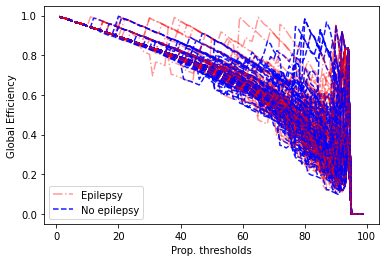

In [756]:
# fig, ax = plt.subplots(2,1, figsize = (10,6))
chosen_files1 = copy(chosen_files)
subst = chosen_files1[1]
chosen_files1[1] = chosen_files1[-1]
chosen_files1[-1] = subst
for filename in chosen_files1:
    color = 'blue'
    legend = 'Epilepsy'
    ls = '--'
    marker = ''
    alpha = 0.9
    # frame = ax[0]
    if 'no_epilepsy' in filename:
        color = 'red'
        legend = 'No epilepsy'
        marker = ''
        ls = '-.'
        alpha = 0.4
    #    frame = ax[1]
    
    plt.plot(dict_ge_by_prop_thresh_normed_mi_raw[filename][:,0],dict_ge_by_prop_thresh_normed_mi_raw[filename][:,1],
            color=color, label=legend, marker=marker, ls=ls,  alpha=alpha) #, ax=frame)
    # plt.title('Mutual Information')
    #  plt.legend(['Mutual Inf'])
    # tick_pos = [1, 5, 10, 15, 20, 25, 30, 35, 40]
    # plt.xticks(ticks=tick_pos, labels=[str(x)+'%' for x in  tick_pos])
    plt.xlabel('Prop. thresholds')
    plt.ylabel('Global Efficiency')
    plt.legend(['Epilepsy', 'No epilepsy'])
    

# plt.savefig('./pdfs/prop_thresh_mi_ge.pdf', dpi=150, bbox_inches='tight')

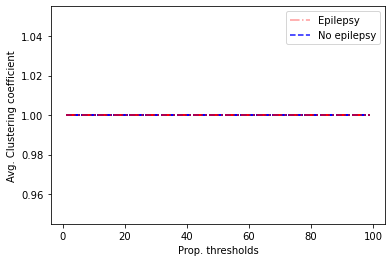

In [757]:
# fig, ax = plt.subplots(2,1, figsize = (10,6))
chosen_files1 = copy(chosen_files)
subst = chosen_files1[1]
chosen_files1[1] = chosen_files1[-1]
chosen_files1[-1] = subst
for filename in chosen_files1:
    color = 'blue'
    legend = 'Epilepsy'
    ls = '--'
    marker = ''
    alpha = 0.9
    # frame = ax[0]
    if 'no_epilepsy' in filename:
        color = 'red'
        legend = 'No epilepsy'
        marker = ''
        ls = '-.'
        alpha = 0.4
    #    frame = ax[1]
    
    plt.plot(dict_clus_coef_by_prop_thresh_normed_mi_raw[filename][:,0],dict_clus_coef_by_prop_thresh_normed_mi_raw[filename][:,1],
            color=color, label=legend, marker=marker, ls=ls,  alpha=alpha) #, ax=frame)
    # plt.title('Mutual Information')
    #  plt.legend(['Mutual Inf'])
    # tick_pos = [1, 5, 10, 15, 20, 25, 30, 35, 40]
    # plt.xticks(ticks=tick_pos, labels=[str(x)+'%' for x in  tick_pos])
    plt.xlabel('Prop. thresholds')
    plt.ylabel('Avg. Clustering coefficient')
    plt.legend(['Epilepsy', 'No epilepsy'])
    

# plt.savefig('./pdfs/prop_thresh_mi_clus_coef.pdf', dpi=150, bbox_inches='tight')

In [497]:
thresholds = np.arange(1, 100, 1)

dict_ge_by_prop_thresh_corr_raw = {}
dict_clus_coef_by_prop_thresh_corr_raw = {}

for filename in dict_edf_file_corr_matrix.keys():
    corr_matrix = dict_edf_file_corr_matrix[filename].values
    
    thresholds_edges = get_glob_eff_by_prop_thresholds(corr_matrix, thresholds)
    dict_ge_by_prop_thresh_corr_raw[filename] = thresholds_edges
    thresholds_edges = get_avg_cluster_coef_by_prop_thresholds(corr_matrix, thresholds)
    dict_clus_coef_by_prop_thresh_corr_raw[filename] = thresholds_edges

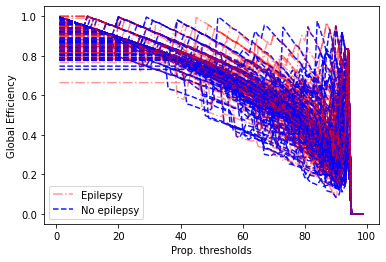

In [580]:
# fig, ax = plt.subplots(2,1, figsize = (10,6))

for filename in chosen_files1:
    color = 'blue'
    legend = 'Epilepsy'
    ls = '--'
    marker = ''
    alpha = 0.9
    # frame = ax[0]
    if 'no_epilepsy' in filename:
        color = 'red'
        legend = 'No epilepsy'
        marker = ''
        ls = '-.'
        alpha = 0.4
    #    frame = ax[1]
    
    plt.plot(dict_ge_by_prop_thresh_corr_raw[filename][:,0],dict_ge_by_prop_thresh_corr_raw[filename][:,1],
            color=color, label=legend, marker=marker, ls=ls,  alpha=alpha) #, ax=frame)
    # plt.title('Mutual Information')
    # plt.legend(['Mutual Inf'])
    # tick_pos = [1, 5, 10, 15, 20, 25, 30, 35, 40]
    # plt.xticks(ticks=tick_pos, labels=[str(x)+'%' for x in  tick_pos])
    plt.xlabel('Prop. thresholds')
    plt.ylabel('Global Efficiency')
    plt.legend(['Epilepsy', 'No epilepsy'])
    

plt.savefig('./pdfs/prop_thresh_corr.pdf', dpi=150, bbox_inches='tight')

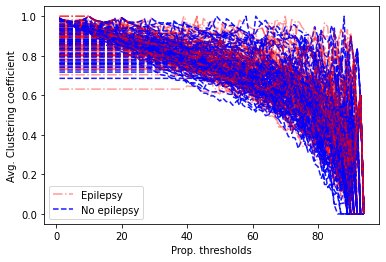

In [579]:
# fig, ax = plt.subplots(2,1, figsize = (10,6))

for filename in chosen_files1:
    color = 'blue'
    legend = 'Epilepsy'
    ls = '--'
    marker = ''
    alpha = 0.9
    # frame = ax[0]
    if 'no_epilepsy' in filename:
        color = 'red'
        legend = 'No epilepsy'
        marker = ''
        ls = '-.'
        alpha = 0.4
    #    frame = ax[1]
    
    plt.plot(dict_clus_coef_by_prop_thresh_corr_raw[filename][:,0],dict_clus_coef_by_prop_thresh_corr_raw[filename][:,1],
            color=color, label=legend, marker=marker, ls=ls,  alpha=alpha) #, ax=frame)
    # plt.title('Mutual Information')
    # plt.legend(['Mutual Inf'])
    # tick_pos = [1, 5, 10, 15, 20, 25, 30, 35, 40]
    # plt.xticks(ticks=tick_pos, labels=[str(x)+'%' for x in  tick_pos])
    plt.xlabel('Prop. thresholds')
    plt.ylabel('Avg. Clustering coefficient')
    plt.legend(['Epilepsy', 'No epilepsy'])
    

plt.savefig('./pdfs/prop_thresh_corr_clus_coef.pdf', dpi=150, bbox_inches='tight')

In [ ]:
df_ge_no_epilepsy = pd.DataFrame([v for v in dict_ge_by_prop_thresh_normed_mi_raw.values()][0][:,0], columns=['thresholds'])
df_ge_epilepsy = pd.DataFrame([v for v in dict_ge_by_prop_thresh_normed_mi_raw.values()][0][:,0], columns=['thresholds'])


idx_no_ep = 1
idx_ep = 1
for k in dict_ge_by_prop_thresh_normed_mi_raw.keys():
    ge_vals = dict_ge_by_prop_thresh_normed_mi_raw[k][:,1]
    if 'no_epilepsy' in k:
        df_ge_no_epilepsy[idx_no_ep] = ge_vals
        idx_no_ep += 1
    else:
        df_ge_epilepsy[idx_ep] = ge_vals
        idx_ep += 1



In [ ]:
df_clus_coef_mi_no_epilepsy = pd.DataFrame([v for v in dict_clus_coef_by_prop_thresh_normed_mi_raw.values()][0][:,0],
                                            columns=['thresholds'])
df_clus_coef_mi_epilepsy = pd.DataFrame([v for v in dict_clus_coef_by_prop_thresh_normed_mi_raw.values()][0][:,0],
                                         columns=['thresholds'])


idx_no_ep = 1
idx_ep = 1
for k in dict_clus_coef_by_prop_thresh_normed_mi_raw.keys():
    ge_vals = dict_clus_coef_by_prop_thresh_normed_mi_raw[k][:,1]
    if 'no_epilepsy' in k:
        df_clus_coef_mi_no_epilepsy[idx_no_ep] = ge_vals
        idx_no_ep += 1
    else:
        df_clus_coef_mi_epilepsy[idx_ep] = ge_vals
        idx_ep += 1

In [482]:
from scipy import stats
for i in range(1, 99, 1):
    st, pv = stats.ttest_ind(df_ge_no_epilepsy.iloc[i,1:].values,
                df_ge_epilepsy.iloc[i,1:].values)
    if pv < 0.1:
        print(df_ge_no_epilepsy.iloc[i,0], st, pv)

36.0 2.147074906990897 0.03300320494295779
38.0 1.6821493910272167 0.09411625184508156
45.0 1.6762432429985403 0.09526879000473203
46.0 1.8051495994902582 0.07257046497234006
47.0 1.861211670174874 0.06419656755564088
49.0 1.7149317098075991 0.08792229224251642
50.0 2.145366578223617 0.03314130361180279
51.0 1.9153468313335558 0.05688924453144986
52.0 1.762225779039734 0.07957419198993962
54.0 1.841573245975531 0.06703351668290292
55.0 1.7133525025153338 0.0882128817886046
93.0 1.6903391809692692 0.09253674623478596


In [ ]:
df_ge_no_epilepsy_corr = pd.DataFrame([v for v in dict_ge_by_prop_thresh_corr_raw.values()][0][:,0], columns=['thresholds'])
df_ge_epilepsy_corr = pd.DataFrame([v for v in dict_ge_by_prop_thresh_corr_raw.values()][0][:,0], columns=['thresholds'])

idx_no_ep = 1
idx_ep = 1
for k in dict_ge_by_prop_thresh_corr_raw.keys():
    ge_vals = dict_ge_by_prop_thresh_corr_raw[k][:,1]
    if 'no_epilepsy' in k:
        df_ge_no_epilepsy_corr[idx_no_ep] = ge_vals
        idx_no_ep += 1
    else:
        df_ge_epilepsy_corr[idx_ep] = ge_vals
        idx_ep += 1


In [586]:
from scipy import stats
for i in range(1, 99, 1):
    st, pv = stats.ttest_ind(df_ge_no_epilepsy_corr.iloc[i,1:].values,
                df_ge_epilepsy_corr.iloc[i,1:].values)

    if pv < 0.06:
        print(i, df_ge_no_epilepsy_corr.iloc[i,0], st, pv)

19 20.0 2.283756716987717 0.023446999338438846
20 21.0 2.246929885892446 0.025748133750957986
21 22.0 2.441015612407957 0.015525011892592592
22 23.0 2.4467738899326865 0.015286521018696493
23 24.0 2.417882015234708 0.01651671592131591
24 25.0 2.451306977931339 0.015101065981200798
25 26.0 2.325485228338997 0.021058770941257708
26 27.0 1.958256989114638 0.05160450901781988
27 28.0 1.9080215963105676 0.05783527816843477
49 50.0 1.9108373877077702 0.057470079161134204
50 51.0 1.936071210206512 0.05428277010147181
54 55.0 1.9136972555683422 0.05710114317111657
55 56.0 2.1731348588486896 0.03095730187140867
56 57.0 2.249184048724359 0.02560182655244729
57 58.0 2.2158736344107286 0.027839241347530977
58 59.0 2.491990179136855 0.013524016187746925
59 60.0 2.69419462814471 0.0076617803758169895
60 61.0 2.726842977534596 0.006968384095005826
61 62.0 2.481214332388703 0.013926780825427773
62 63.0 2.3683350133101464 0.01883128034448841
63 64.0 2.7178242796303813 0.0071540157094190015
64 65.0 2.85

In [600]:
print('       ', 'no epilepsy', 'epilepsy', 't-test score', 'p-value')
print('mean:', df_ge_no_epilepsy.iloc[49,1:].mean().round(3), df_ge_epilepsy.iloc[49,1:].mean().round(3), 2.145, 0.033)
print('std:', df_ge_no_epilepsy.iloc[49,1:].std().round(3), df_ge_epilepsy.iloc[49,1:].std().round(3))

# 50.0 2.145 0.033

        no epilepsy epilepsy t-test score p-value
mean: 0.744 0.732 2.145 0.033
std: 0.043 0.032


In [598]:
print('       ', 'no epilepsy', 'epilepsy', 't-test score', 'p-value')
print('mean:', df_ge_no_epilepsy_corr.iloc[49,1:].mean().round(3), df_ge_epilepsy_corr.iloc[49,1:].mean().round(3), 1.911, 0.057)
print('std:', df_ge_no_epilepsy_corr.iloc[49,1:].std().round(3), df_ge_epilepsy_corr.iloc[49,1:].std().round(3))

# 50.0 1.911 0.057

        no epilepsy epilepsy t-test score p-value
mean: 0.74 0.721 1.91 0.057
std: 0.069 0.066


In [ ]:
from scipy import stats
for i in range(1, 99, 1):
    st, pv = stats.ttest_ind(df_clus_coef_mi_no_epilepsy.iloc[i,1:].values,
                df_clus_coef_mi_epilepsy.iloc[i,1:].values)
    if pv < 0.1:
        print(df_clus_coef_mi_no_epilepsy.iloc[i,0], st, pv)

## 3.5 Overall Functional Connectivity

In [382]:
thresholds = np.arange(1, 40, 1)

dict_prop_thresh_normed_mi_raw = {}

for filename in dict_edf_file_normed_mi_matrix.keys():
    normed_mi_matrix = dict_edf_file_normed_mi_matrix[filename]
    
    thresholds_edges = get_n_edges_by_prop_thresholds(normed_mi_matrix, thresholds)
    dict_prop_thresh_normed_mi_raw[filename] = thresholds_edges

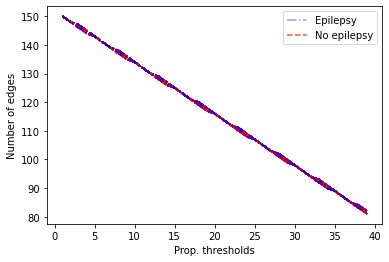

In [585]:
# fig, ax = plt.subplots(2,1, figsize = (10,6))
for filename in chosen_files1:
    color = 'red'
    legend = 'Epilepsy'
    ls = '--'
    marker = ''
    alpha = 0.7
    # frame = ax[0]
    if 'no_epilepsy' in filename:
        color = 'blue'
        legend = 'No epilepsy'
        marker = ''
        ls = '-.'
        alpha = 0.4
        # frame = ax[1]
    
    plt.plot(dict_prop_thresh_normed_mi_raw[filename][:,0],dict_prop_thresh_normed_mi_raw[filename][:,1],
            color=color, label=legend, marker=marker, ls=ls, alpha=alpha) #, ax=frame)
    # plt.title('NMI, Proportional thresholding')
    #  plt.legend(['Mutual Inf'])
    plt.xlabel('Prop. thresholds')
    plt.legend(['Epilepsy', 'No epilepsy'])
    plt.ylabel('Number of edges')

# plt.savefig('./pdfs/normed_mi_num_edges_prop_thresh.pdf', dpi=150, bbox_inches='tight')

# Bands

In [135]:
import joblib

dict_edf_file_normed_mi_matrix_bands = joblib.load('./matrices/mi_matrices_for_bands.data' )

In [150]:
dict_betti_normed_mi_all = {}

for filename in dict_edf_file_normed_mi_matrix.keys():
    normed_mi_matrix = dict_edf_file_normed_mi_matrix_bands[filename]['beta'][0]
    
    thresholds_edges = get_betti_by_thresholds(normed_mi_matrix, thresholds)
    dict_betti_normed_mi_all[filename] = thresholds_edges


In [313]:
connected_components((np.abs(normed_mi_matrix) > 0.5))  

(3,
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0],
       dtype=int32))

In [252]:
list(dict_betti_normed_mi_all.values())[0].shape#,:,-1]

(100, 4)

# PCA


In [ ]:
df_epilepsy, channels = read_edf_to_pandas(edf_file_epilepsy)

In [203]:
df_epilepsy

FP1       FP2        F7        F3            FZ            F4  \
0      -0.000055 -0.000034 -0.000066 -0.000044 -3.546596e-05 -3.663714e-05   
1      -0.000053 -0.000024 -0.000067 -0.000055 -2.643116e-05 -3.094856e-05   
2      -0.000057 -0.000037 -0.000072 -0.000054 -3.730638e-05 -3.914681e-05   
3      -0.000062 -0.000049 -0.000074 -0.000044 -4.767967e-05 -4.466807e-05   
4      -0.000060 -0.000037 -0.000070 -0.000045 -3.847756e-05 -3.680445e-05   
...          ...       ...       ...       ...           ...           ...   
309243 -0.000014  0.000021 -0.000021 -0.000020  1.175178e-06  2.275831e-05   
309244 -0.000022  0.000015 -0.000037 -0.000038  3.386223e-07  1.539662e-05   
309245 -0.000033 -0.000009 -0.000051 -0.000035 -1.789829e-05  5.059334e-07   
309246 -0.000042 -0.000021 -0.000058 -0.000025 -2.643116e-05 -4.848023e-06   
309247 -0.000044 -0.000010 -0.000061 -0.000032 -1.438476e-05  1.509800e-06   

              F8        T3        C3        CZ            C4        T4  \
0      -0.000025 -0.000061 -0.000019 -0.000011 -1.823291e-05 -0.000022   
1      -0.000014 -0.000055 -0.000013 -0.000005 -1.204240e-05 -0.000012   
2      -0.000029 -0.000068 -0.000025 -0.000013 -2.007334e-05 -0.000027   
3      -0.000041 -0.000078 -0.000035 -0.000021 -2.609654e-05 -0.000038   
4      -0.000028 -0.000068 -0.000025 -0.000013 -1.806560e-05 -0.000026   
...          ...       ...       ...       ...           ...       ...   
309243  0.000013 -0.000012 -0.000012 -0.000012 -6.521134e-06  0.000007   
309244  0.000003 -0.000022 -0.000014 -0.000008 -6.652445e-07 -0.000001   
309245 -0.000028 -0.000047 -0.000033 -0.000016 -8.528868e-06 -0.000032   
309246 -0.000046 -0.000062 -0.000043 -0.000018 -9.532735e-06 -0.000049   
309247 -0.000036 -0.000057 -0.000033 -0.000006  2.346356e-06 -0.000040   

              T5        P3        PZ        P4        T6        O1  \
0      -0.000046 -0.000023 -0.000015 -0.000013 -0.000017 -0.000019   
1      -0.000046 -0.000016 -0.000011 -0.000011 -0.000009 -0.000035   
2      -0.000051 -0.000028 -0.000019 -0.000019 -0.000021 -0.000030   
3      -0.000054 -0.000038 -0.000026 -0.000022 -0.000031 -0.000016   
4      -0.000050 -0.000028 -0.000020 -0.000015 -0.000021 -0.000019   
...          ...       ...       ...       ...       ...       ...   
309243 -0.000019  0.000007  0.000006  0.000036  0.000025 -0.000014   
309244 -0.000032  0.000003  0.000003  0.000029  0.000016 -0.000040   
309245 -0.000048 -0.000020 -0.000007  0.000014 -0.000014 -0.000036   
309246 -0.000060 -0.000034 -0.000013  0.000005 -0.000031 -0.000037   
309247 -0.000067 -0.000027 -0.000010  0.000006 -0.000025 -0.000058   

                  O2  
0      -3.306223e-07  
1       7.365690e-06  
2      -6.521134e-06  
3      -1.789829e-05  
4      -7.023068e-06  
...              ...  
309243  4.484338e-05  
309244  3.396816e-05  
309245  2.179045e-06  
309246 -1.789829e-05  
309247 -1.220971e-05  

[309248 rows x 19 columns]

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# Here we have the data standarized ready to apply PCA 
# for that, we use the scale() function form sklearn 

y = StandardScaler().fit_transform(df_epilepsy)
y = pd.DataFrame(y, columns=channels) 

####Get the PCA components

pcamodel = PCA(n_components=3)
pca = pcamodel.fit_transform(y)
ax = sns.heatmap(pcamodel.components_ ,
cmap='plasma', #'YlGnBu',
yticklabels=[ "PCA"+str(y) for y in range(1,pcamodel. n_components_+1)],
xticklabels=list(y.columns),
cbar_kws={"orientation": "vertical"}) 
ax.set_aspect("equal")
# plt.title('P. component contr by channel deoxyhb')

# Plot cumulative explained variance
# Initialize up to the number of component that explains 90% of the variance.

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [90.0%] explained variance using the [19] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [90.00%] explained variance.
[pca] >The PCA reduction is performed on the [19] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[6]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


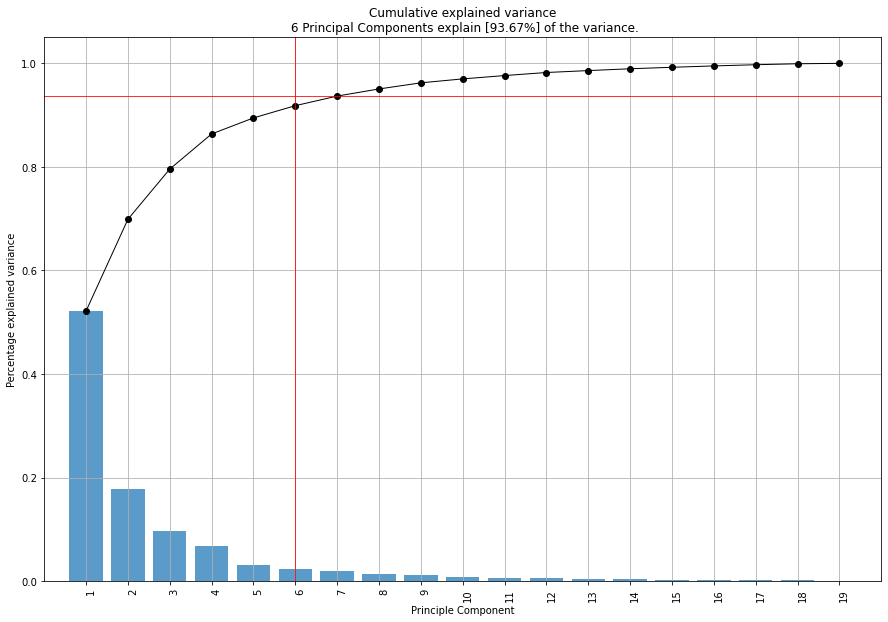

<Figure size 432x288 with 0 Axes>

In [212]:
from pca import pca
model = pca(n_components=0.9)
# Fit transform
results = model.fit_transform(y)
#plot figure
fig, ax = model.plot()

In [99]:
df_no_epilepsy, channels = read_edf_to_pandas(chosen_files[0])

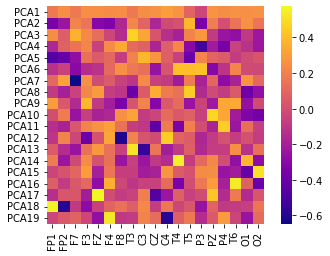

In [102]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# Here we have the data standarized ready to apply PCA 
# for that, we use the scale() function form sklearn 

y = StandardScaler().fit_transform(df_no_epilepsy)
y = pd.DataFrame(y, columns=channels) 

####Get the PCA components

pcamodel = PCA(n_components=19)
pca = pcamodel.fit_transform(y)
ax = sns.heatmap(pcamodel.components_ ,
cmap='plasma', #'YlGnBu',
yticklabels=[ "PCA"+str(i) for i in range(1,pcamodel. n_components_+1)],
xticklabels=list(y.columns),
cbar_kws={"orientation": "vertical"}) 
ax.set_aspect("equal")
# plt.title('P. component contr by channel deoxyhb')
plt.savefig('./pdfs/pca_correlation_map_epilepsy.pdf', dpi=150, bbox_inches='tight')

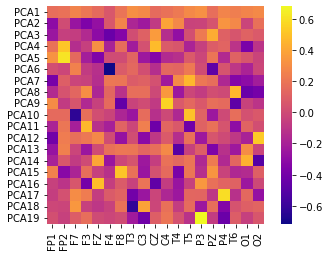

In [103]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# Here we have the data standarized ready to apply PCA 
# for that, we use the scale() function form sklearn 
df_no_epilepsy, channels = read_edf_to_pandas(chosen_files[100])

y = StandardScaler().fit_transform(df_no_epilepsy)
y = pd.DataFrame(y, columns=channels) 

####Get the PCA components

pcamodel = PCA(n_components=19)
pca = pcamodel.fit_transform(y)
ax = sns.heatmap(pcamodel.components_ ,
cmap='plasma', #'YlGnBu',
yticklabels=[ "PCA"+str(i) for i in range(1,pcamodel. n_components_+1)],
xticklabels=list(y.columns),
cbar_kws={"orientation": "vertical"}) 
ax.set_aspect("equal")
# plt.title('P. component contr by channel deoxyhb')
plt.savefig('./pdfs/pca_correlation_map_no_epilepsy.pdf', dpi=150, bbox_inches='tight')

In [ ]:
# Plot cumulative explained variance
# Initialize up to the number of component that explains 90% of the variance.

from pca import pca
model = pca(n_components=0.9)
# Fit transform
results = model.fit_transform(y)
#plot figure
fig, ax = model.plot()

In [ ]:
from pca import pca

d_pca_results={}
i=0
for f in chosen_files:
    i += 1
    print(i)

    df, ch = read_edf_to_pandas(f)
    
    y = StandardScaler().fit_transform(df)
    y = pd.DataFrame(y, columns=ch)

    model = pca(n_components=0.9)
    results = model.fit_transform(y, verbose=0)

    d_pca_results[f] = (results,model)


In [225]:
# joblib.dump(value=d_pca_results, filename='d_pca_results.data')

['d_pca_results.data']

In [78]:
d_pca_results = joblib.load('d_pca_results.data')

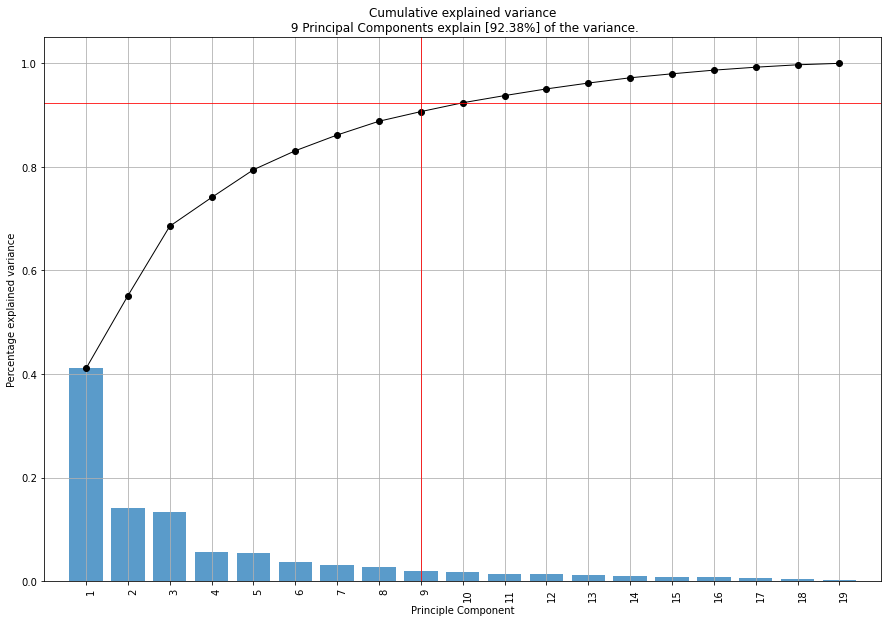

<Figure size 432x288 with 0 Axes>

In [91]:
# for f in [chosen_files[0],chosen_files[100]] :
fig, ax = d_pca_results[chosen_files[100]][1].plot()
fig.savefig('pdfs/pca_explained_var_no_epilepsy.pdf', dpi=150, bbox_inches='tight')

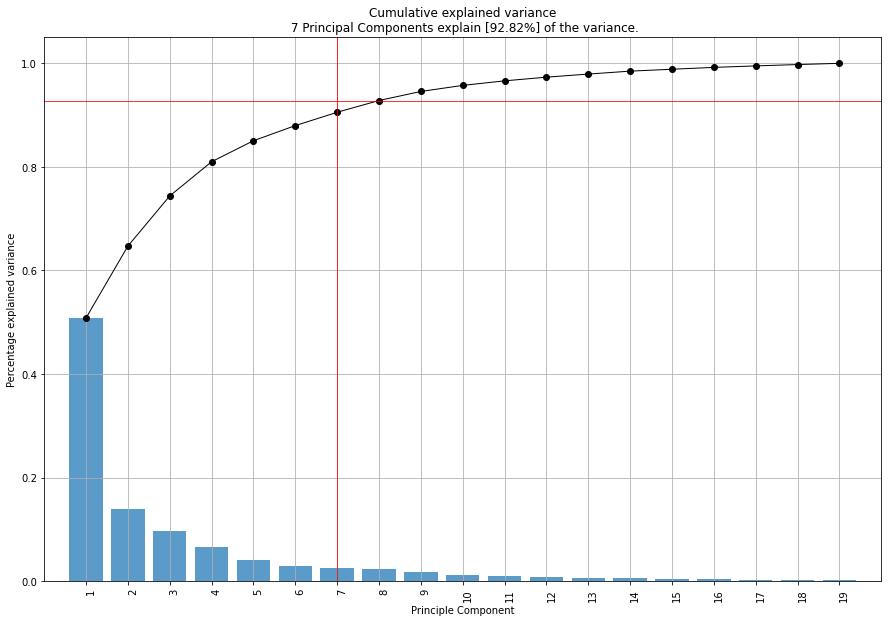

<Figure size 432x288 with 0 Axes>

In [90]:
# for f in [chosen_files[0],chosen_files[100]] :
fig, ax = d_pca_results[chosen_files[0]][1].plot()
fig.savefig('pdfs/pca_explained_var_epilepsy.pdf', dpi=150, bbox_inches='tight')

In [224]:
def plot_normed_mutual_information_matrix_band(edf_filename, band=None):
    """ Reads edf file from relative path (ex. ../tuh_eeg_epilepsy/edf/*/*/*/*/*/*.edf). 
        Creates a dataframe with all EEG readings from all channels.
        Computes a normalized mutual information matrix.
    """
    
    dict_edf_file_normed_mi_matrix_bands = joblib.load('./matrices/mi_matrices_for_bands.data')
    if not band:
        
        fig, ax = plt.subplots(5,2, figsize=(9,24))
        for i,b in enumerate(['all', 'delta', 'theta', 'alpha', 'beta']):
            # plot the heatmap for mutual information matrix
            normed_mi_matrix = dict_edf_file_normed_mi_matrix_bands[edf_filename][b][0]
            corr_matrix = dict_edf_file_normed_mi_matrix_bands[edf_filename][b][1]
            channel_labels = corr_matrix.columns.tolist()

            g0 = sns.heatmap(normed_mi_matrix,
                        xticklabels=channel_labels, 
                        yticklabels=channel_labels,
                        cmap= plt.cm.jet,
                        ax = ax[i,0])

            g0.set_title('Mutual Information Matrix, freq. band: "{}"'.format(b))
            #ax[0,i].set_xlabel('channel_names')
            #ax[0,i].set_ylabel('channel_names')       

            g1 = sns.heatmap(corr_matrix,
            xticklabels=channel_labels, 
            yticklabels=channel_labels,
            cmap= plt.cm.jet,
            ax = ax[i,1])

            g1.set_title('Correlation Matrix, freq. band: "{}"'.format(b))
            # ax[1,i].set_xlabel('channel_names')
            # ax[1,i].set_ylabel('channel_names')
        
    else:
        normed_mi_matrix = dict_edf_file_normed_mi_matrix_bands[edf_filename][band][0]
        corr_matrix = dict_edf_file_normed_mi_matrix_bands[edf_filename][band][1]
        channel_labels = corr_matrix.columns.tolist()
        # plot the heatmap for mutual information matrix
        fig, ax = plt.subplots(1,1, figsize=(8,6))
        sns.heatmap(corr_matrix,
                    xticklabels=channel_labels, 
                    yticklabels=channel_labels,
                    cmap= plt.cm.jet,
                    ax = ax)

        plt.title('Correlation Matrix')
        # plt.xlabel('channel_names')
        # plt.ylabel('channel_names')

In [182]:
chosen_files[100]

'../tuh_eeg_epilepsy/edf/no_epilepsy/01_tcp_ar/086/00008684/s001_2011_11_09/00008684_s001_t000.edf'

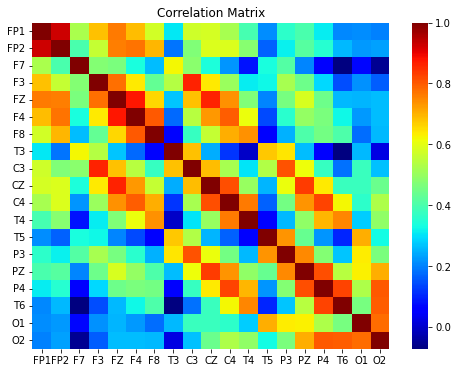

In [225]:
plot_normed_mutual_information_matrix_band(chosen_files[0], band='all')
plt.savefig('./pdfs/corr_all_epilepsy.pdf', dpi=150, bbox_inches='tight')

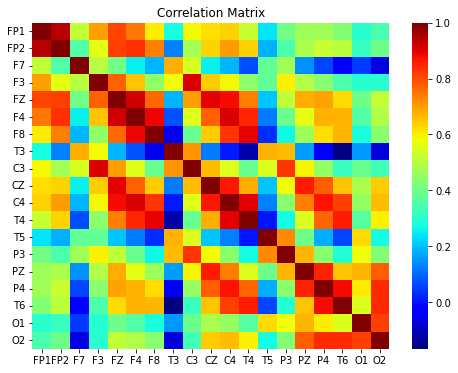

In [226]:
plot_normed_mutual_information_matrix_band(chosen_files[0], band='delta')
# plt.savefig('./pdfs/corr_delta_epilepsy.pdf', dpi=150, bbox_inches='tight')

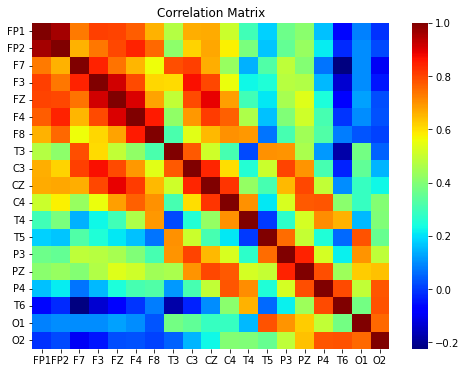

In [227]:
plot_normed_mutual_information_matrix_band(chosen_files[0], band='theta')
# plt.savefig('./pdfs/corr_theta_epilepsy.pdf', dpi=150, bbox_inches='tight')

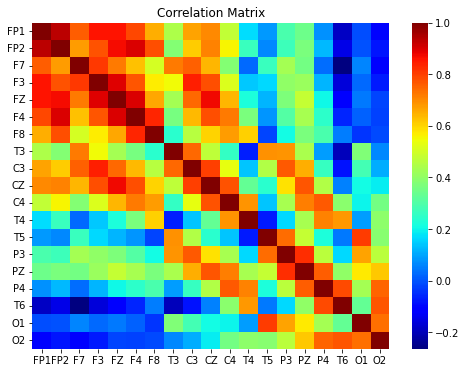

In [228]:
plot_normed_mutual_information_matrix_band(chosen_files[0], band='alpha')
# plt.savefig('./pdfs/corr_alpha_epilepsy.pdf', dpi=150, bbox_inches='tight')

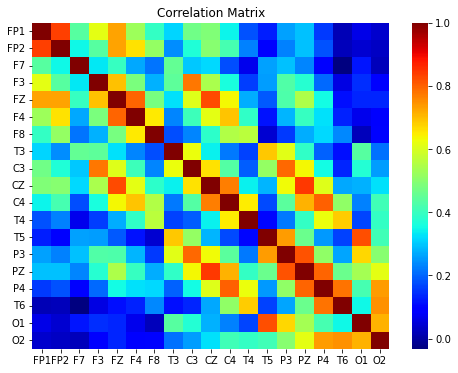

In [229]:
plot_normed_mutual_information_matrix_band(chosen_files[0], band='beta')
# plt.savefig('./pdfs/corr_beta_epilepsy.pdf', dpi=150, bbox_inches='tight')

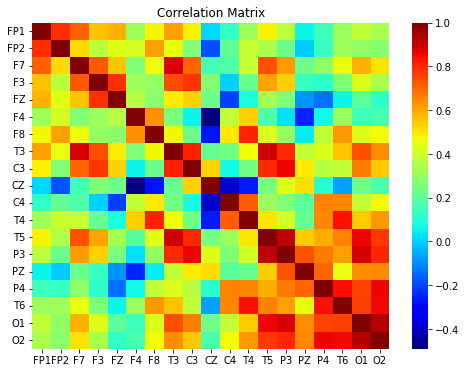

In [230]:
plot_normed_mutual_information_matrix_band(chosen_files[100], band='all')
plt.savefig('./pdfs/corr_all_no_epilepsy.pdf', dpi=150, bbox_inches='tight')

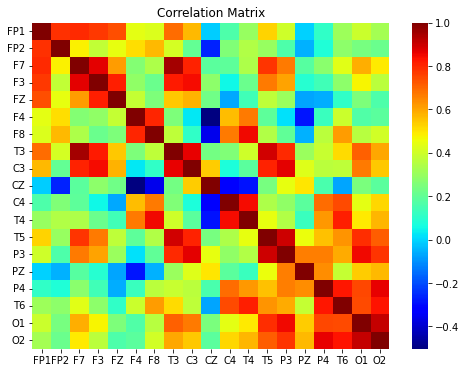

In [231]:
plot_normed_mutual_information_matrix_band(chosen_files[100], band='delta')
# plt.savefig('./pdfs/corr_delta_no_epilepsy.pdf', dpi=150, bbox_inches='tight')

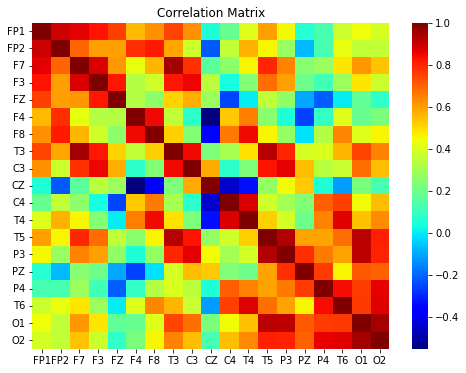

In [232]:
plot_normed_mutual_information_matrix_band(chosen_files[100], band='theta')
# plt.savefig('./pdfs/corr_dtheta_no_epilepsy.pdf', dpi=150, bbox_inches='tight')

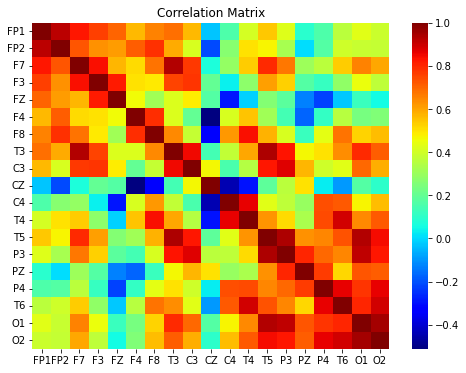

In [233]:
plot_normed_mutual_information_matrix_band(chosen_files[100], band='alpha')
# plt.savefig('./pdfs/corr_alpha_no_epilepsy.pdf', dpi=150, bbox_inches='tight')

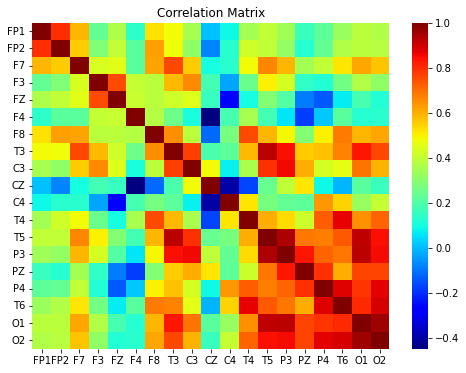

In [234]:
plot_normed_mutual_information_matrix_band(chosen_files[100], band='beta')
# plt.savefig('./pdfs/corr_beta_no_epilepsy.pdf', dpi=150, bbox_inches='tight')

# Plotting 

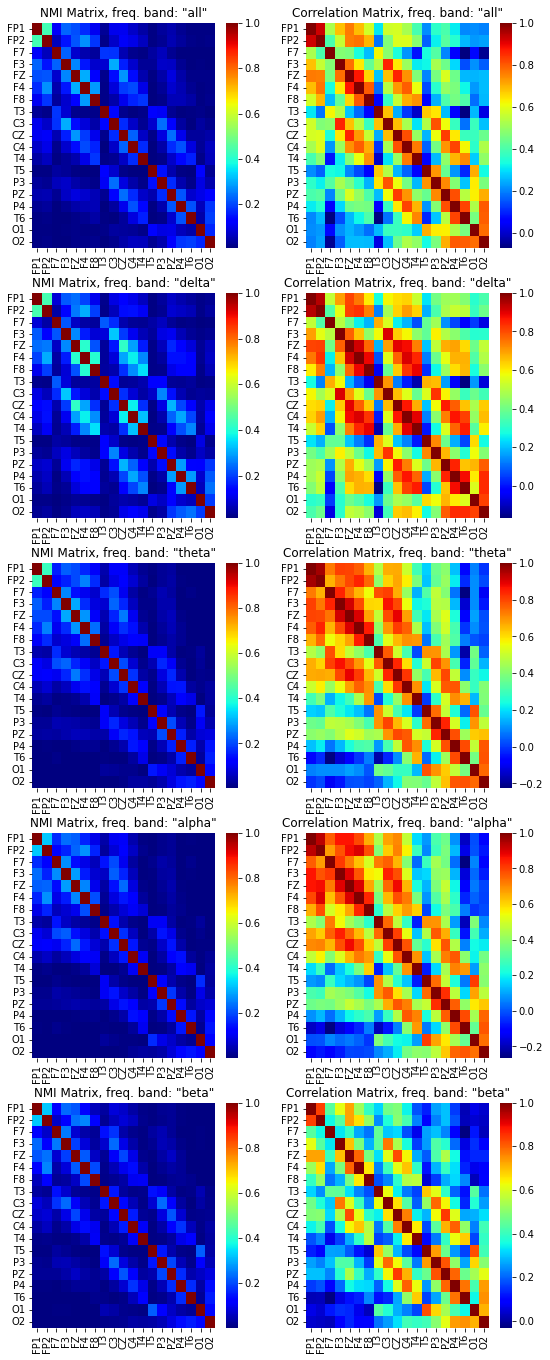

In [119]:
plot_normed_mutual_information_matrix_band(chosen_files[0])
# plt.savefig('./pdfs/nmi_corr_for_bands_epilepsy.pdf', dpi=150, bbox_inches='tight')

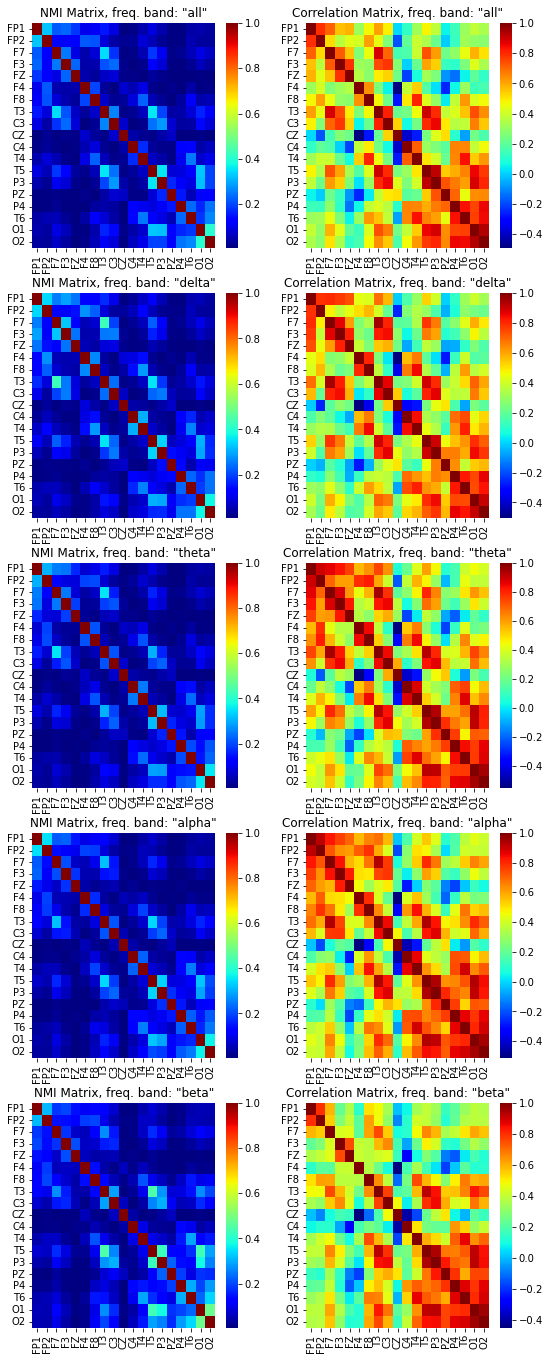

In [120]:
plot_normed_mutual_information_matrix_band(chosen_files[100])
# plt.savefig('./pdfs/nmi_corr_for_bands_no_epilepsy.pdf', dpi=150, bbox_inches='tight')